# Analyzing Taxi Trends: Descriptive Analytics & Hypothesis Testing


## Objective
 To analyze passenger preferences by comparing local cab services and rideshare platforms like uber, our goal is to identify the factors influencing passenger choices, such as fare amounts, payment methods, passenger satisfaction score and overall ride experience to provide actionable insights to improve service offerings.

## Source

Data collected from Hugging Face Datasets.


## **Setup**

For this lab, we will be using the following libraries:
 - [`pandas`](https://pandas.pydata.org/) for managing the data.
 - [`numpy`](https://numpy.org/) for mathematical operations.
 - [`seaborn`](https://seaborn.pydata.org/) for visualizing the data.
 - [`matplotlib`](https://matplotlib.org/) for visualizing the data.
 - [`sklearn`](https://scikit-learn.org/stable/) for machine learning and machine-learning-pipeline related functions.
 - [`scipy`](https://docs.scipy.org/doc/scipy/tutorial/stats.html/) for statistical computations.


## **Import the required libraries**


In [66]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler


import statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm,AnovaRM 


from scipy.stats import kstest, levene, f_oneway, ttest_ind, mannwhitneyu,norm ,stats,chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_gameshowell

In [2]:
import warnings 
warnings.filterwarnings('ignore')

## **Reading and understanding our data**


In [3]:
taxis = pd.read_csv('../data/taxis.csv')
df=taxis.copy()
taxis.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
pickup,2019-03-23 20:21:09,2019-03-04 16:11:55,2019-03-27 17:53:01,2019-03-10 01:23:59,2019-03-30 13:27:42
dropoff,2019-03-23 20:27:24,2019-03-04 16:19:00,2019-03-27 18:00:25,2019-03-10 01:49:51,2019-03-30 13:37:14
passengers,1,1,1,1,3
distance,1.6,0.79,1.37,7.7,2.16
fare,7.0,5.0,7.5,27.0,9.0
tip,2.15,0.0,2.36,6.15,1.1
tolls,0.0,0.0,0.0,0.0,0.0
total,12.95,9.3,14.16,36.95,13.4
color,yellow,yellow,yellow,yellow,yellow


We can find more information about the features and types using the `info()`  method.


In [4]:
taxis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       6433 non-null   int64  
 1   pickup           6433 non-null   object 
 2   dropoff          6433 non-null   object 
 3   passengers       6433 non-null   int64  
 4   distance         6433 non-null   float64
 5   fare             6433 non-null   float64
 6   tip              6433 non-null   float64
 7   tolls            6433 non-null   float64
 8   total            6433 non-null   float64
 9   color            6433 non-null   object 
 10  payment          6389 non-null   object 
 11  pickup_zone      6407 non-null   object 
 12  dropoff_zone     6388 non-null   object 
 13  pickup_borough   6407 non-null   object 
 14  dropoff_borough  6388 non-null   object 
dtypes: float64(5), int64(2), object(8)
memory usage: 754.0+ KB


According to the output above, we have 6433 entries, ranging from 0 to 6432, as well as 15 features. The "Non-Null Count" column shows the number of non-null entries. If the count is 6433, then there are no missing values for that particular feature. 'total' could be considered our target or response variable, and the rest of the features are our predictor variables.

We also have a mix of numerical (2 int64 and 5 float64) and object data types. Notably, some features like 'payment', 'pickup_zone', 'dropoff_zone', 'pickup_borough', and 'dropoff_borough' have missing values, as their non-null counts are less than 6433. This indicates the need for handling missing data during preprocessing.

Next, let's use the `describe()` function to show the count, mean, min, max of the fare attribute.


In [5]:
taxis['fare'].describe().T

count    6433.000000
mean       13.091073
std        11.551804
min         1.000000
25%         6.500000
50%         9.500000
75%        15.000000
max       150.000000
Name: fare, dtype: float64

Based on the provided descriptive statistics for the "fare" variable, several observations can be made. The minimum value of 1.000000 is greater than 0, which is a positive indicator. However, there is a notable difference between the minimum value and the 25th percentile (6.500000), as well as between the 75th percentile (15.000000) and the maximum value (150.000000). This significant spread in the data, particularly the large gap between the 75th percentile and the maximum value, suggests that the distribution of the "fare" variable may not be normal. This is an important consideration, as normality is a key assumption for linear regression analysis. To address this, we will explore the normality of the data further in the Log Transform section.

In [6]:
features = taxis.columns
features

Index(['Unnamed: 0', 'pickup', 'dropoff', 'passengers', 'distance', 'fare',
       'tip', 'tolls', 'total', 'color', 'payment', 'pickup_zone',
       'dropoff_zone', 'pickup_borough', 'dropoff_borough'],
      dtype='object')

# *Performing analysis on clone dataset*

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'passengers'}>,
        <Axes: title={'center': 'distance'}>],
       [<Axes: title={'center': 'fare'}>,
        <Axes: title={'center': 'tip'}>,
        <Axes: title={'center': 'tolls'}>],
       [<Axes: title={'center': 'total'}>, <Axes: >, <Axes: >]],
      dtype=object)

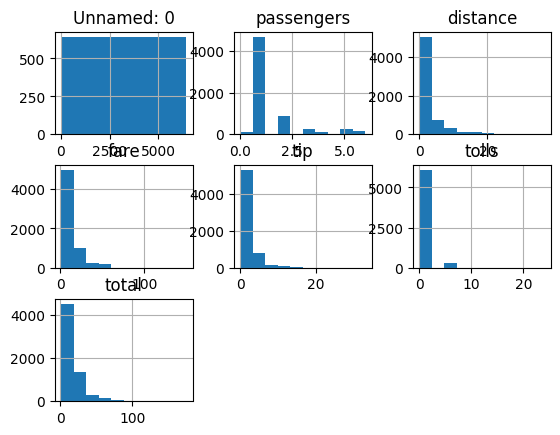

In [7]:
df.hist()

In [8]:
Num_features = [feature for feature in features if df[feature].dtype != object]
Cat_features = [feature for feature in features if df[feature].dtype == object]
Num_features


['Unnamed: 0', 'passengers', 'distance', 'fare', 'tip', 'tolls', 'total']

In [9]:
Cat_features

['pickup',
 'dropoff',
 'color',
 'payment',
 'pickup_zone',
 'dropoff_zone',
 'pickup_borough',
 'dropoff_borough']

In [10]:
df  = df.fillna(method="bfill")

In [11]:
df.isnull().sum()

Unnamed: 0         0
pickup             0
dropoff            0
passengers         0
distance           0
fare               0
tip                0
tolls              0
total              0
color              0
payment            0
pickup_zone        0
dropoff_zone       0
pickup_borough     0
dropoff_borough    0
dtype: int64

# Plan for Data Exploration

In the data exploration phase, we will perform the following steps to gain insights into the dataset:

- Histograms: Plot histograms for all numerical features to visualize their distributions and identify potential skewness or outliers.

- Boxplots: Create boxplots for numerical features to detect outliers and understand the spread of the data.

- Correlation Matrix: Generate a correlation matrix to examine relationships between numerical variables and identify potential multicollinearity.

- Subplots of Numerical Features: Use subplots to display all numerical features in a single view for easier comparison and analysis.

- Countplots of Categorical Variables: Plot countplots for categorical variables to understand the distribution of categories and identify any imbalances.

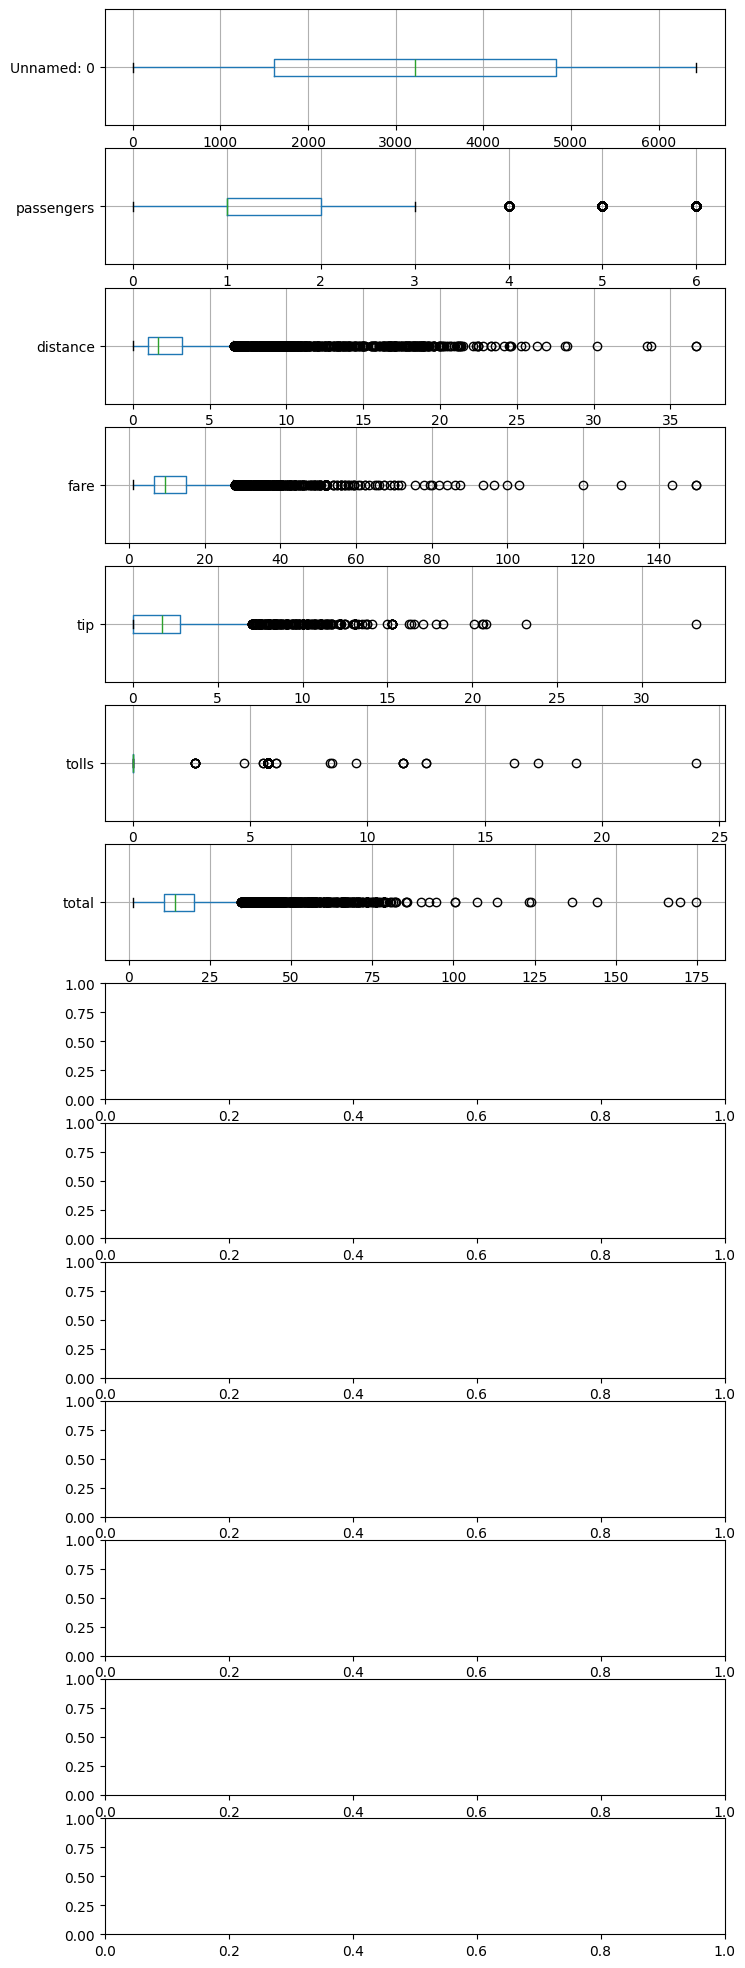

In [12]:
fig, axes = plt.subplots(14,1 ,figsize=(8,25))

for i,c in enumerate(Num_features):
    f = df[[c]].boxplot(ax=axes[i], vert=False)

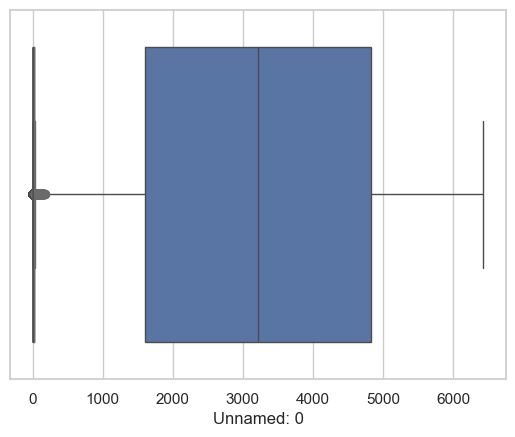

In [13]:
import seaborn as sns

sns.set_theme(style="whitegrid")
for i, c in enumerate(Num_features):
    ax = sns.boxplot(x = df[c])


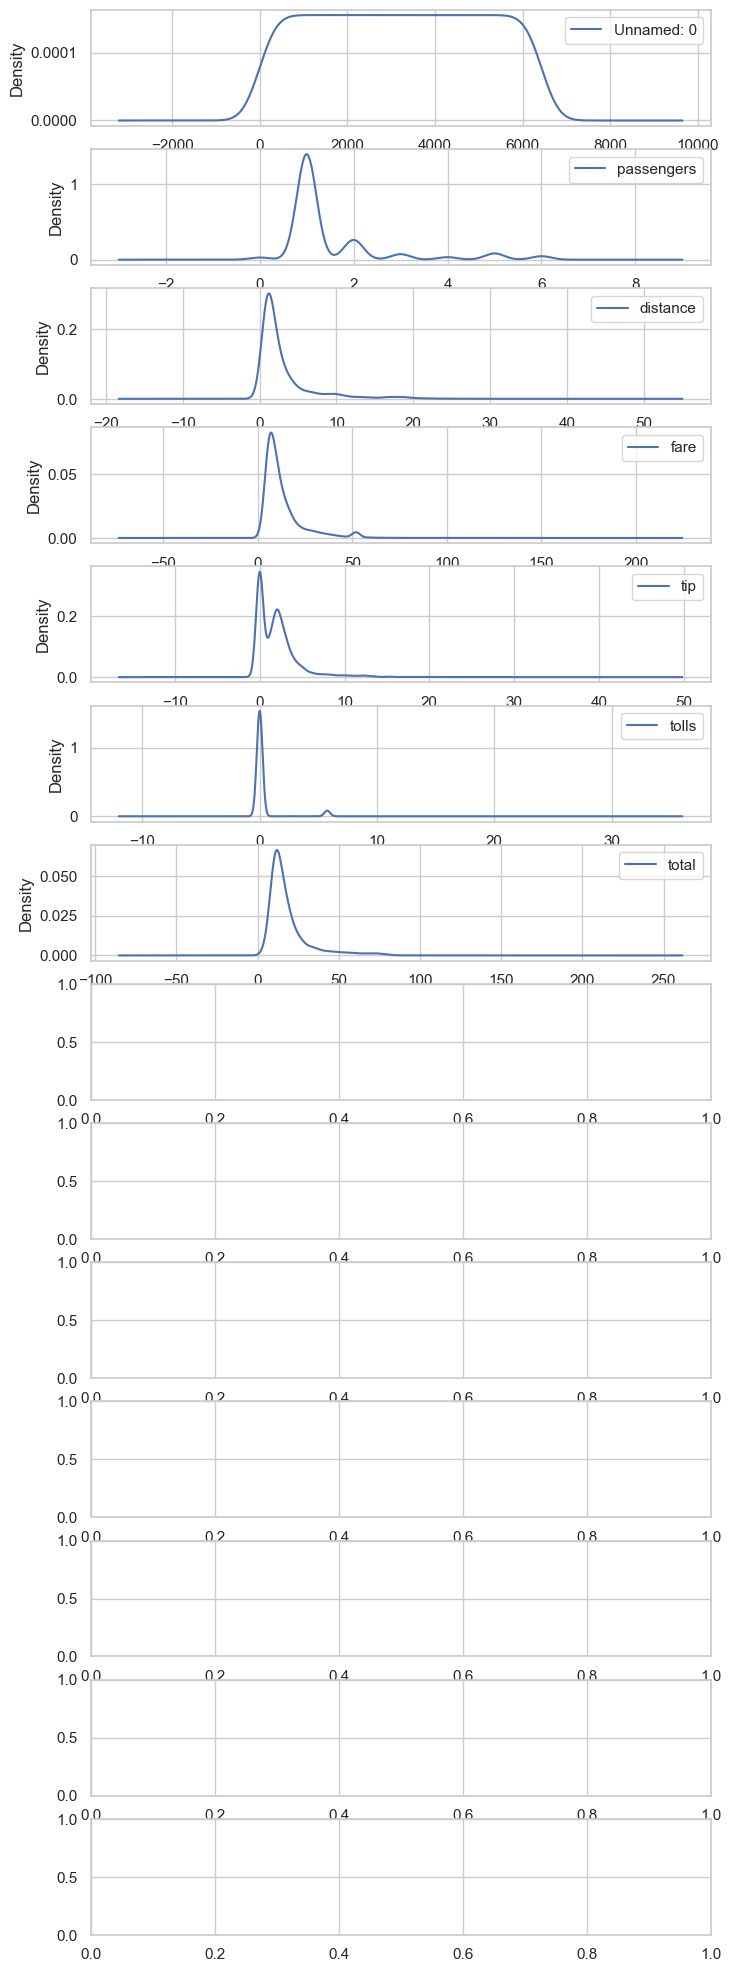

In [14]:
fig, axes = plt.subplots(14,1 ,figsize=(8,25))

for i,c in enumerate(Num_features):
    f = df[[c]].plot(kind = 'kde', ax=axes[i])

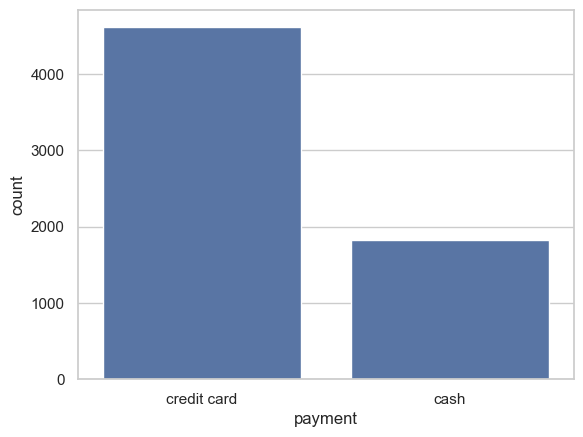

In [15]:
# For categorical features

countplot = sns.countplot(x="payment",data=df)


In [16]:
df_mean = df[Num_features].mean()
df_mean

Unnamed: 0    3216.000000
passengers       1.539251
distance         3.024617
fare            13.091073
tip              1.979220
tolls            0.325273
total           18.517794
dtype: float64

In [17]:
# df_n = df.groupby('payment').mean()

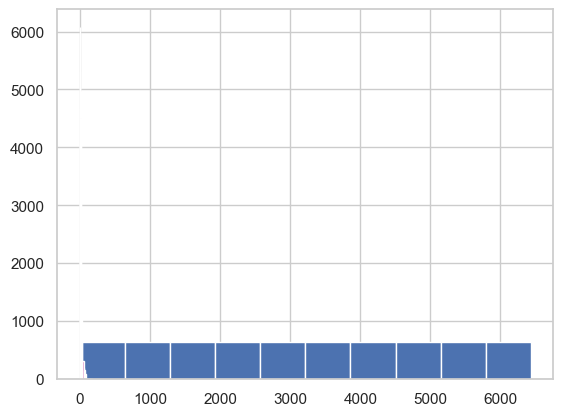

In [18]:
for r in Num_features:
    df[r].hist()

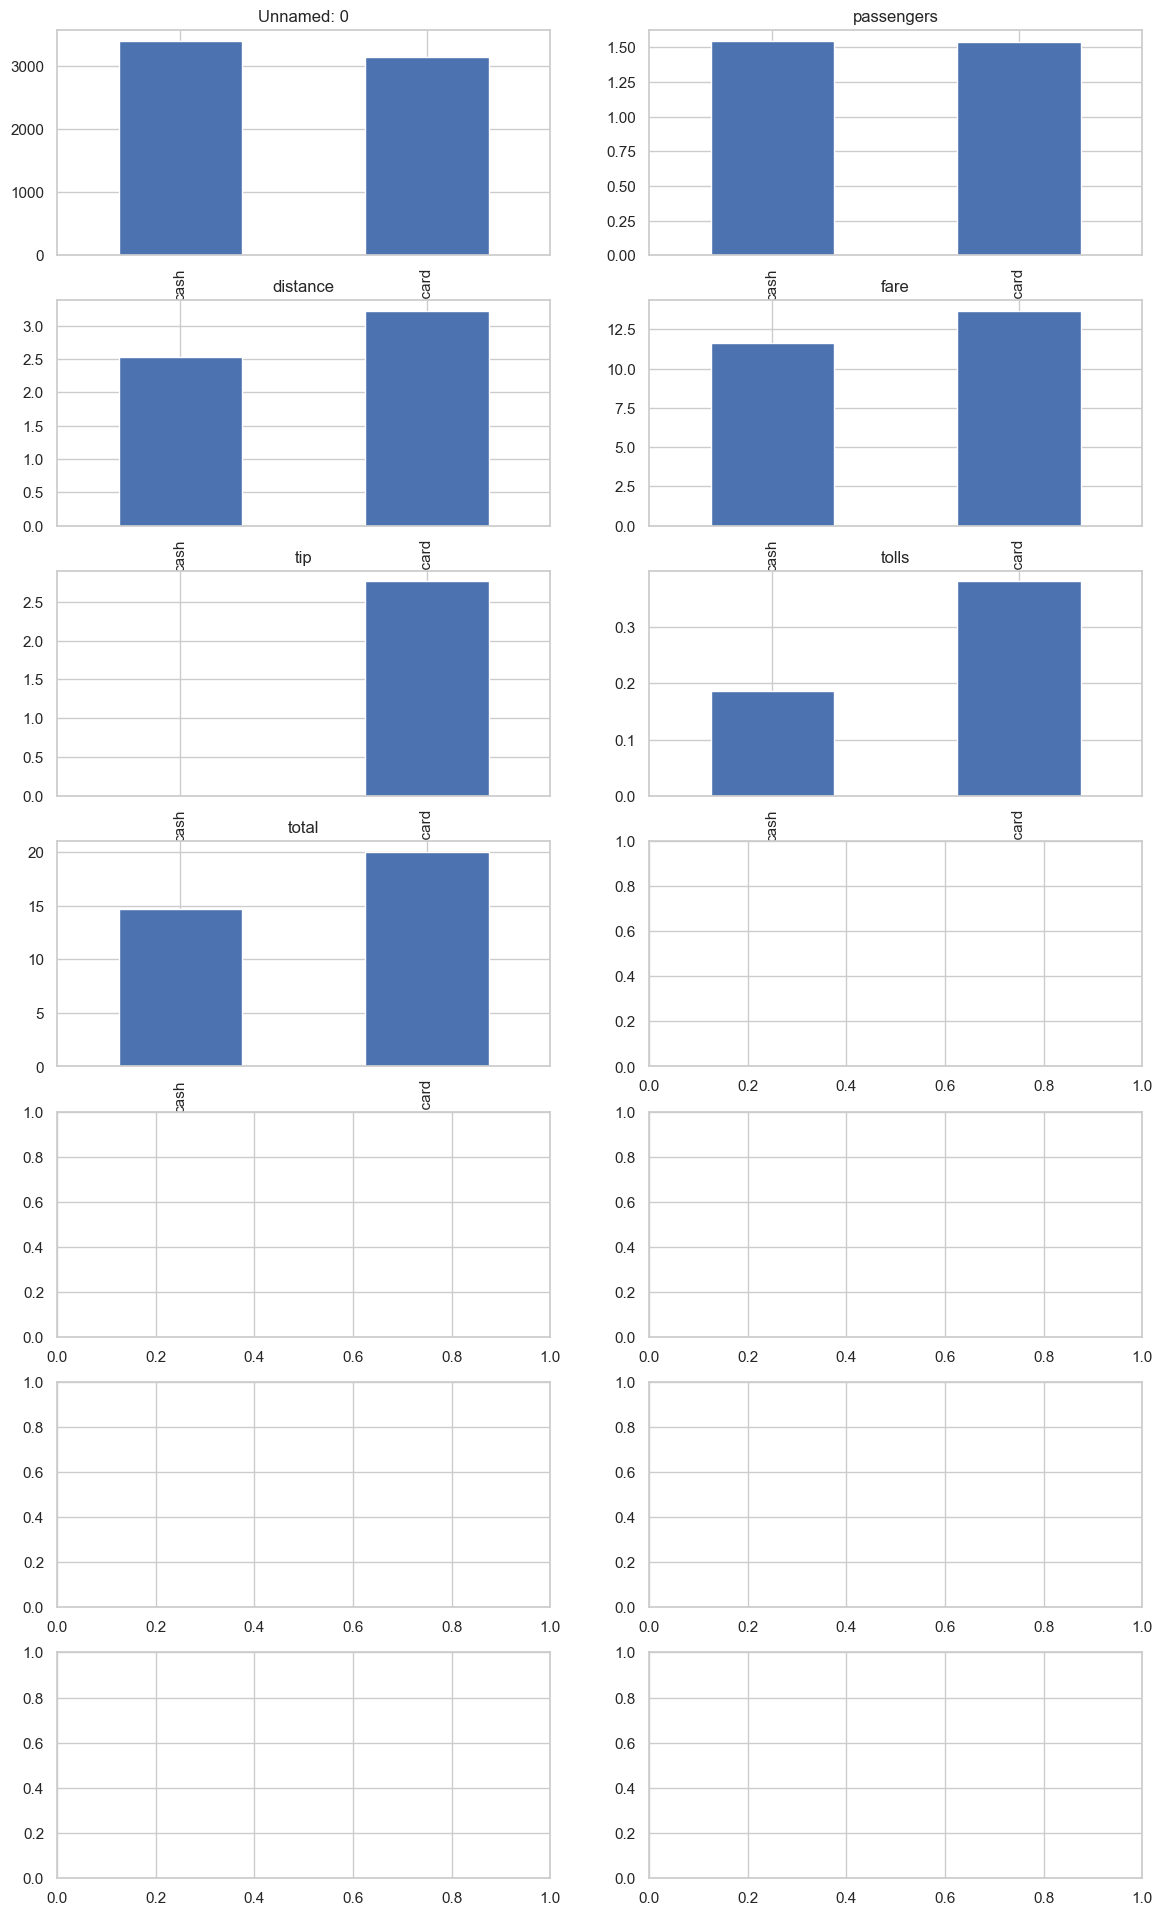

In [19]:
# Relationship between all features mean and our targer feature
fix, axes = plt.subplots(7,2, figsize=(14,24))
axes = [ax for axes_row in axes for ax in axes_row]

for i,c in enumerate(df[Num_features]):
    df_n = df.groupby('payment')[c].mean()
    plot = df_n.plot(kind='bar',title=c,ax=axes[i])

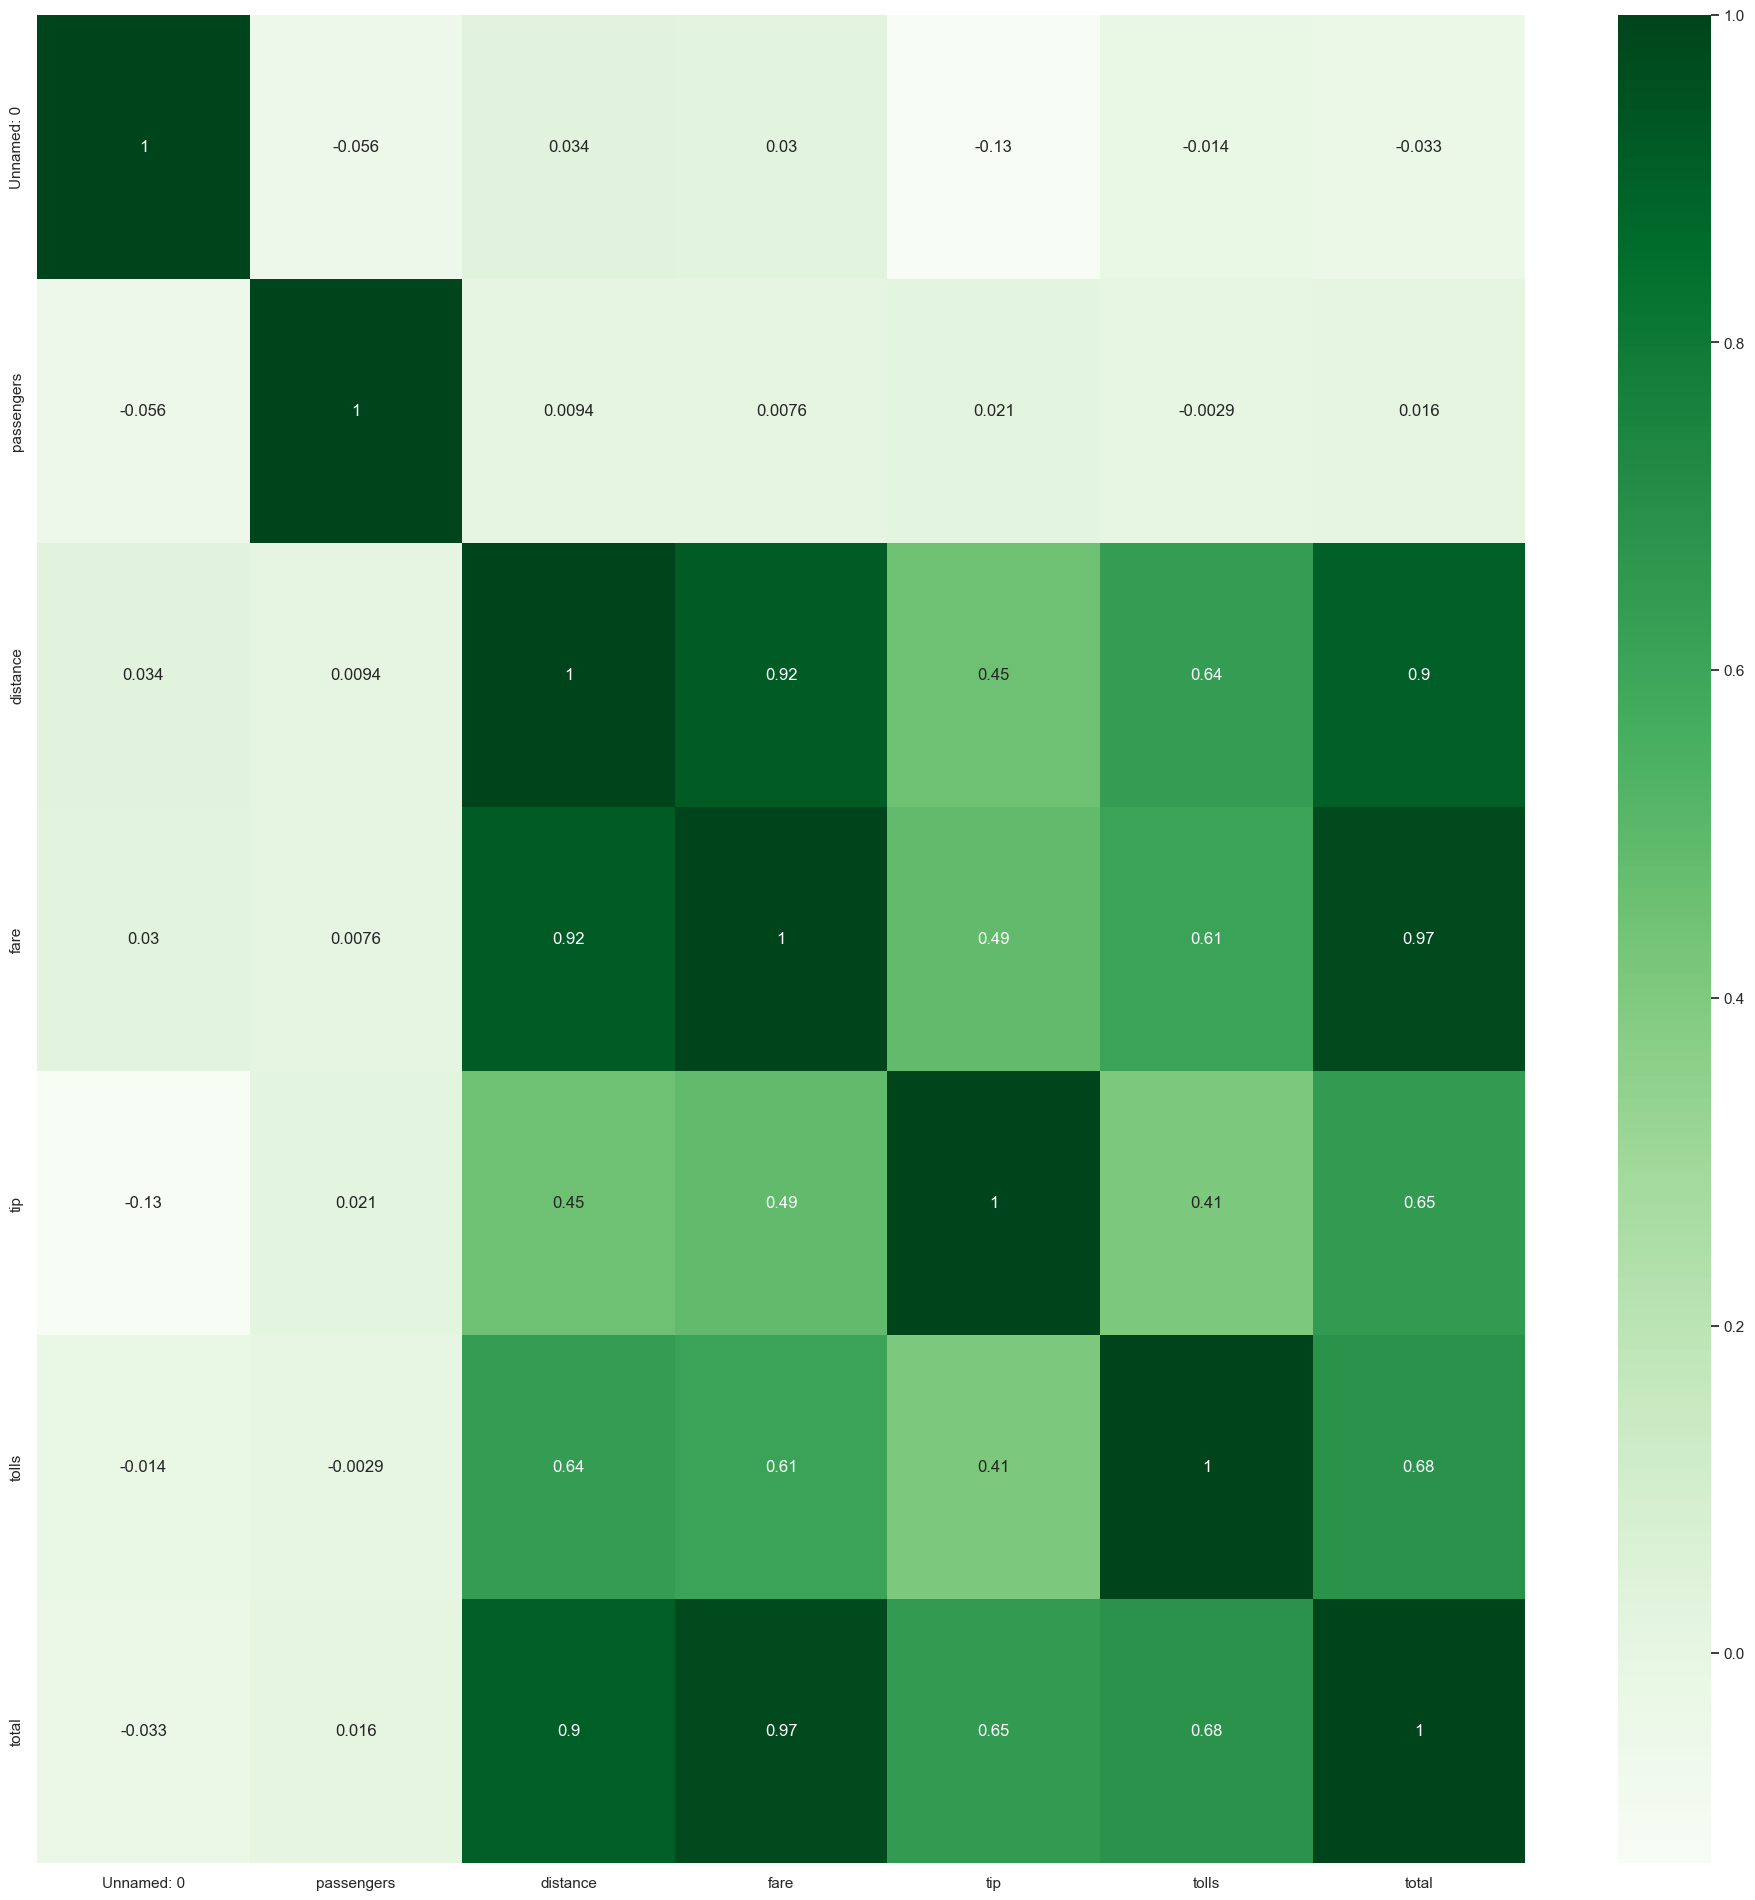

In [20]:
# Pearson Correlation matrix

corr_matrix = df[Num_features].corr(method='pearson')
plt.figure(figsize=(24,24))
correc = sns.heatmap(corr_matrix, annot=True, cmap = 'Greens')

In [21]:
# Find features with high and low correlation
df['payment'] = df.payment.map({"cash":0, "credit card":1})

df

,Unnamed: 0,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,1,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,0,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,1,Alphabet City,West Village,Manhattan,Manhattan
3,3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,1,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,1,Midtown East,Yorkville West,Manhattan,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,1,East Harlem North,Central Harlem North,Manhattan,Manhattan
6429,6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,1,Jamaica,East Concourse/Concourse Village,Queens,Bronx
6430,6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,0,Crown Heights North,Bushwick North,Brooklyn,Brooklyn
6431,6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,1,East New York,East Flatbush/Remsen Village,Brooklyn,Brooklyn


In [22]:
Cat_features
# filtering the dataset
df_filtered = df.drop(columns=['Unnamed: 0','pickup',
 'dropoff',
 'color',
 'payment',
 'pickup_zone',
 'dropoff_zone',
 'pickup_borough',
 'dropoff_borough'])


correlation_matrix = df_filtered.corr()


correlation_matrix.T

,passengers,distance,fare,tip,tolls,total
passengers,1.000000,0.009411,0.007637,0.021099,-0.002903,0.015708
distance,0.009411,1.000000,0.920108,0.452589,0.635267,0.904676
fare,0.007637,0.920108,1.000000,0.488612,0.609307,0.974358
tip,0.021099,0.452589,0.488612,1.000000,0.413619,0.646186
tolls,-0.002903,0.635267,0.609307,0.413619,1.000000,0.683142
total,0.015708,0.904676,0.974358,0.646186,0.683142,1.000000


# Actions Taken for Data Cleaning and Feature Engineering

**1. Handling Null Values**

All null values were addressed using the forward fill method, given that they constituted less than 0.5% of the data. This decision ensured that data integrity was preserved while minimizing the impact of missing values.

**2. Separating Variables**

Numerical and categorical variables were segregated to allow for tailored preprocessing. This separation facilitated the application of specific techniques suited to the data type, optimizing the cleaning and transformation process.

**3. Feature Selection**

A correlation matrix analysis was conducted, and features with negligible relationships to the target variable (total) were removed. This reduced dimensionality, focusing on significant predictors and improving the efficiency of subsequent modeling.

## Key Findings and Insights

**1. Correlation Analysis**

Insights from the correlation matrix are as follows:

* **Distance and Fare:**
    * Distance showed a strong positive correlation with Fare (0.920) and Total (0.905). This indicates that longer trips inherently incur higher fares and totals, confirming their importance in cost prediction.
    * Fare demonstrates the highest correlation with Total (0.974), making it the most critical single predictor of the overall trip cost.

* **Tips:**
    * The correlation of Tip with Total (0.646) and Fare (0.489) indicates that tipping behavior is influenced by the fare amount and overall trip cost. However, this relationship is moderate rather than strong.

* **Tolls:**
    * The moderate correlation of Tolls with Total (0.683) and Distance (0.635) highlights that tolls are typically associated with longer trips and contribute meaningfully to total trip costs.

* **Passengers:**
    * Passengers displays minimal correlation with other features (maximum correlation: 0.021 with Tip), suggesting its irrelevance in predicting Total.

**2. Distribution of Values**

Feature distributions were analyzed for skewness and outliers. While skewness was observed in some variables, robust scaling effectively normalized the data, ensuring consistency across features.

**3. Feature-Target Relationship**

A deeper analysis revealed that Fare and Distance are the most influential features for predicting Total. Their dominance underscores the foundational role of trip length and base cost in determining overall expenses.

## Correlation Matrix

| Feature      | Passengers | Distance | Fare   | Tip   | Tolls  | Total  |
|--------------|------------|----------|-------|-------|-------|-------|
| Passengers   | 1.000000   | 0.009411 | 0.007637| 0.021099| -0.002903| 0.015708|
| Distance     | 0.009411   | 1.000000 | 0.920108| 0.452589| 0.635267| 0.904676|
| Fare         | 0.007637   | 0.920108 | 1.000000| 0.488612| 0.609307| 0.974358|
| Tip          | 0.021099   | 0.452589 | 0.488612| 1.000000| 0.413619| 0.646186|
| Tolls        | -0.002903  | 0.635267 | 0.609307| 0.413619| 1.000000| 0.683142|
| Total        | 0.015708   | 0.904676 | 0.974358| 0.646186| 0.683142| 1.000000|

## Actionable Insights

1. **Feature Importance:** Focus on Fare and Distance, as they are the most significant predictors of Total. These variables should be prioritized in model development to ensure accurate cost prediction.

2. **Feature Removal:** Passengers can be excluded from the dataset as it does not contribute meaningfully to the prediction of Total. This simplification reduces noise and enhances model performance.

3. **Outlier Handling:** The application of robust scaling successfully mitigated the impact of outliers, ensuring the data's suitability for machine learning and statistical analysis.

4. **Modeling Strategy:** Focus on features with strong correlations (Fare, Distance, Tip, and Tolls) when building predictive models. Additionally, consider interactions between Distance and Tolls or Fare and Tip for advanced feature engineering.

## Statistical Interpretation

The dataset encapsulates essential taxi trip data, highlighting Fare and Distance as the most significant determinants of the total trip cost. Moderate contributions from Tips and Tolls further refine the model's explanatory power. Passengers, with negligible correlation to Total, is an irrelevant predictor and can be omitted. Robust preprocessing has rendered the data well-suited for predictive modeling, ensuring both accuracy and reliability.

This analysis serves as a foundation for model training, emphasizing the critical role of trip length and fare in shaping total costs, while addressing the nuances of additional charges like tips and tolls.

## **Feature Transformation**
Feature Transformation means transforming our features to the functions of the original features. For example, feature encoding, scaling, and discretization (the process of transforming continuous variables into discrete form, by creating bins or intervals) are the most common forms of data transformation.


### **Dealing with Categorical Variables**

Categorical variables represent qualitative data with no apparent inherent mathematical meaning. Therefore, for any machine learning analysis, all the categorical data must be transformed into the numerical data types. 


In [23]:
df['color'].unique()

array(['yellow', 'green'], dtype=object)

In [24]:
replace_color={
    'yellow':0,
    'green':1
}
df['color_new']=df['color'].replace(replace_color).astype(int)

In [25]:
print(df['pickup_borough'].unique(),df['dropoff_borough'].unique())

['Manhattan' 'Queens' 'Bronx' 'Brooklyn'] ['Manhattan' 'Queens' 'Brooklyn' 'Bronx' 'Staten Island']


In [26]:
replace_borough={'Manhattan':0, 'Queens':1, 'Brooklyn':2, 'Bronx':3, 'Staten Island':4}

df['pickup_borough_new'] =df['pickup_borough'].replace(replace_borough).astype(int)
df['dropoff_borough_new'] =df['dropoff_borough'].replace(replace_borough).astype(int)


In [27]:
pickup=df['pickup_zone'].unique()
dropoff=df['dropoff_zone'].unique()
pickup,dropoff

(array(['Lenox Hill West', 'Upper West Side South', 'Alphabet City',
        'Hudson Sq', 'Midtown East', 'Times Sq/Theatre District',
        'Battery Park City', 'Murray Hill', 'East Harlem South',
        'Lincoln Square East', 'LaGuardia Airport', 'Lincoln Square West',
        'Financial District North', 'Upper West Side North',
        'East Chelsea', 'Midtown Center', 'Gramercy',
        'Penn Station/Madison Sq West', 'Sutton Place/Turtle Bay North',
        'West Chelsea/Hudson Yards', 'Clinton East', 'Clinton West',
        'UN/Turtle Bay South', 'Midtown South', 'Midtown North',
        'Garment District', 'Lenox Hill East', 'Flatiron',
        'TriBeCa/Civic Center', 'Upper East Side North', 'West Village',
        'Greenwich Village South', 'JFK Airport', 'East Village',
        'Union Sq', 'Yorkville West', 'Central Park',
        'Meatpacking/West Village West', 'Kips Bay', 'Morningside Heights',
        'Astoria', 'East Tremont', 'Upper East Side South',
        'Financ

# Handling Pickup and Dropoff Zones

During the data preprocessing phase, we encountered the `pickup` and `dropoff` zones, which represent specific locations within boroughs. While we successfully converted the `pickup` and `dropoff` boroughs into manageable categorical variables, the zones presented a significant challenge. 

## Residential 

### Key Observations: 
1) **High Cardinality**: 
    - The `pickup` and `dropoff` zones contain more than 100 unique locations each. 
    - Such high cardinality makes it difficult to encode these features effectively without significantly increasing the dimensionality of the dataset. 

2) **Impact on Model Performance**: 
    - Including these zones would require one-hot encoding or similar techniques, leading to a sparse and computationally expensive dataset. 
    - This could also introduce noise and reduce the model's ability to generalize. 

## Airport

### Decision: 
To address this issue, we decided to **drop the `pickup` and `dropoff` zones** from the dataset. While these features could potentially provide granular location-based insights, their high cardinality and complexity outweigh their benefits in this context. 

## Commercial

### Alternative Approach: 
Instead of using the zones, we retained the `pickup` and `dropoff` boroughs, which provide sufficient geographical context for analysis and modeling. This approach strikes a balance between retaining useful information and maintaining dataset manageability. 

## Tourist Spot

### Impact: 
- **Simplified Dataset**: Dropping the zones reduces the dataset's complexity, making it easier to process and analyze. 
- **Improved Model Efficiency**: By avoiding high-dimensional encoding, we ensure that the model remains computationally efficient and interpretable. 

This decision aligns with our goal of creating a clean, manageable dataset that supports effective analysis and modeling.

In [28]:
pickzone_to_region = {
    # Airport Zones
    'JFK Airport': 'Airport',
    'LaGuardia Airport': 'Airport',

    # Residential Zones
    'East Village': 'Residential', 'Alphabet City': 'Residential', 'Astoria': 'Residential',
    'Battery Park City': 'Residential', 'Bloomingdale': 'Residential', 'Boerum Hill': 'Residential',
    'Brooklyn Heights': 'Residential', 'Central Harlem': 'Residential', 'Central Harlem North': 'Residential',
    'Cobble Hill': 'Residential', 'Crown Heights North': 'Residential', 'East Concourse/Concourse Village': 'Residential',
    'East Flatbush/Farragut': 'Residential', 'East Harlem North': 'Residential', 'East Harlem South': 'Residential',
    'East New York': 'Residential', 'East Tremont': 'Residential', 'Elmhurst': 'Residential',
    'Flushing': 'Residential', 'Fort Greene': 'Residential', 'Gramercy': 'Residential', 'Greenpoint': 'Residential',
    'Hamilton Heights': 'Residential', 'Kips Bay': 'Residential', 'Lenox Hill East': 'Residential',
    'Lenox Hill West': 'Residential', 'Lincoln Square East': 'Residential', 'Lincoln Square West': 'Residential',
    'Manhattan Valley': 'Residential', 'Manhattanville': 'Residential', 'Morningside Heights': 'Residential',
    'Mott Haven/Port Morris': 'Residential', 'Murray Hill': 'Residential', 'Old Astoria': 'Residential',
    'Park Slope': 'Residential', 'Prospect Heights': 'Residential', 'Queensboro Hill': 'Residential',
    'Ridgewood': 'Residential', 'Rosedale': 'Residential', 'Sunnyside': 'Residential',
    'Upper East Side North': 'Residential', 'Upper East Side South': 'Residential',
    'Upper West Side North': 'Residential', 'Upper West Side South': 'Residential',
    'Washington Heights South': 'Residential', 'Williamsbridge/Olinville': 'Residential',
    'Williamsburg (North Side)': 'Residential', 'Williamsburg (South Side)': 'Residential',
    'Yorkville East': 'Residential', 'Yorkville West': 'Residential',

    # Commercial Zones
    'Clinton East': 'Commercial', 'Clinton West': 'Commercial', 'Downtown Brooklyn/MetroTech': 'Commercial',
    'East Chelsea': 'Commercial', 'Financial District North': 'Commercial', 'Financial District South': 'Commercial',
    'Flatiron': 'Commercial', 'Garment District': 'Commercial', 'Hudson Sq': 'Commercial',
    'Midtown Center': 'Commercial', 'Midtown East': 'Commercial', 'Midtown North': 'Commercial',
    'Midtown South': 'Commercial', 'Seaport': 'Commercial', 'South Ozone Park': 'Commercial',
    'Times Sq/Theatre District': 'Commercial', 'West Chelsea/Hudson Yards': 'Commercial',

    # Tourist Spots
    'Central Park': 'Tourist Spot', 'Chinatown': 'Tourist Spot', 'DUMBO/Vinegar Hill': 'Tourist Spot',
    'Greenwich Village North': 'Tourist Spot', 'Greenwich Village South': 'Tourist Spot',
    'Little Italy/NoLiTa': 'Tourist Spot', 'Lower East Side': 'Tourist Spot', 'Meatpacking/West Village West': 'Tourist Spot',
    'SoHo': 'Tourist Spot', 'TriBeCa/Civic Center': 'Tourist Spot', 'Two Bridges/Seward Park': 'Tourist Spot',
    'Union Sq': 'Tourist Spot', 'West Village': 'Tourist Spot', 'World Trade Center': 'Tourist Spot'
}
dropzone_to_region = {
    # Airports
    'JFK Airport': 'Airport', 
    'LaGuardia Airport': 'Airport',

    # Residential
    'Williamsburg (North Side)': 'Residential', 'Williamsburg (South Side)': 'Residential', 
    'Kips Bay': 'Residential', 'West Village': 'Residential', 'East Village': 'Residential', 
    'Astoria': 'Residential', 'Woodside': 'Residential', 'Elmhurst': 'Residential', 
    'Yorkville West': 'Residential', 'Greenwich Village South': 'Residential', 
    'Yorkville East': 'Residential', 'Crown Heights South': 'Residential', 
    'Greenpoint': 'Residential', 'Jackson Heights': 'Residential', 'Ridgewood': 'Residential',
    'Bushwick North': 'Residential', 'Bushwick South': 'Residential', 
    'Sunnyside': 'Residential', 'Bedford': 'Residential', 'Clinton Hill': 'Residential', 
    'Richmond Hill': 'Residential', 'Steinway': 'Residential', 'Forest Hills': 'Residential',
    'East Williamsburg': 'Residential', 'Fort Greene': 'Residential', 'Middle Village': 'Residential',
    'Mott Haven/Port Morris': 'Residential', 'Inwood': 'Residential', 'Hamilton Heights': 'Residential',
    'Washington Heights South': 'Residential', 'Alphabet City': 'Residential', 'Stuy Town/Peter Cooper Village': 'Residential',
    'Brooklyn Heights': 'Residential', 'Crown Heights North': 'Residential', 'Park Slope': 'Residential',
    'Prospect-Lefferts Gardens': 'Residential', 'Richmond Hill': 'Residential', 'Sunset Park West': 'Residential',
    
    # Commercial
    'Financial District North': 'Commercial', 'Financial District South': 'Commercial', 
    'Garment District': 'Commercial', 'Midtown North': 'Commercial', 'Midtown South': 'Commercial',
    'Hudson Sq': 'Commercial', 'West Chelsea/Hudson Yards': 'Commercial', 
    'Times Sq/Theatre District': 'Commercial', 'Seaport': 'Commercial', 'Flatiron': 'Commercial', 
    'Midtown East': 'Commercial', 'Union Sq': 'Commercial', 'East Flatbush/Farragut': 'Commercial', 
    'Long Island City/Hunters Point': 'Commercial', 'Downtown Brooklyn/MetroTech': 'Commercial', 
    'Meatpacking/West Village West': 'Commercial', 'Sutton Place/Turtle Bay North': 'Commercial',
    'World Trade Center': 'Commercial',

    # Tourist Spots
    'Central Park': 'Tourist Spot', 'Chinatown': 'Tourist Spot', 
    'World Trade Center': 'Tourist Spot', 'TriBeCa/Civic Center': 'Tourist Spot', 
    'Little Italy/NoLiTa': 'Tourist Spot', 'SoHo': 'Tourist Spot', 
    'Union Sq': 'Tourist Spot', 'DUMBO/Vinegar Hill': 'Tourist Spot', 
    'Meatpacking/West Village West': 'Tourist Spot', 'Flushing Meadows-Corona Park': 'Tourist Spot',

    # Uncategorized (now correctly categorized)
    'Melrose South': 'Residential', 'Queensbridge/Ravenswood': 'Residential', 'UN/Turtle Bay South': 'Commercial',
    'Briarwood/Jamaica Hills': 'Residential', 'Two Bridges/Seward Park': 'Residential', 'Penn Station/Madison Sq West': 'Commercial',
    'East Chelsea': 'Residential', 'LaGuardia Airport': 'Airport', 'Lincoln Square West': 'Commercial',
    'Garment District': 'Commercial', 'Upper West Side North': 'Residential', 'Lincoln Square East': 'Commercial',
    'Central Harlem North': 'Residential', 'Upper West Side South': 'Residential', 'Lenox Hill West': 'Residential',
    'Soundview/Castle Hill': 'Residential', 'Downtown Brooklyn/MetroTech': 'Commercial', 'Columbia Street': 'Residential',
    'Murray Hill': 'Residential', 'East Harlem South': 'Residential', 'Williamsbridge/Olinville': 'Residential', 'East Harlem North': 'Residential',
    'Clinton East': 'Residential', 'Upper East Side South': 'Residential', 'Lenox Hill East': 'Residential',
    'Inwood': 'Residential', 'Clinton West': 'Residential', 'Sutton Place/Turtle Bay North': 'Commercial',
    'Gramercy': 'Residential', 'Washington Heights South': 'Residential', 'Alphabet City': 'Residential',
    'Stuyvesant Heights': 'Residential', 'Greenwich Village North': 'Residential', 'Manhattan Valley': 'Residential',
    'Lenox Hill East': 'Residential', 'Inwood': 'Residential', 'Clinton West': 'Residential', 'Sutton Place/Turtle Bay North': 'Residential',
    'Gramercy': 'Residential', 'Financial District South': 'Commercial', 'Greenpoint': 'Residential', 'Jackson Heights': 'Residential',
    'Carroll Gardens': 'Residential', 'East Flushing': 'Residential', 'Prospect Heights': 'Residential', 'Cypress Hills': 'Residential',
    'Crown Heights North': 'Residential', 'Boerum Hill': 'Residential', 'Sunset Park West': 'Residential',
    'Long Island City/Queens Plaza': 'Residential', 'North Corona': 'Residential', 'Woodhaven': 'Residential',
    'Woodlawn/Wakefield': 'Residential', 'Riverdale/North Riverdale/Fieldston': 'Residential', 'Baisley Park': 'Residential',
    'Sheepshead Bay': 'Residential', 'Howard Beach': 'Residential', 'Canarsie': 'Residential', 'Queens Village': 'Residential',
    'South Jamaica': 'Residential', 'Clinton Hill': 'Residential', 'Richmond Hill': 'Residential', 'Old Astoria': 'Residential',
    'Steinway': 'Residential', 'East Flatbush/Farragut': 'Residential', 'Washington Heights North': 'Residential',
    'Flushing Meadows-Corona Park': 'Tourist Spot', 'Williamsburg (South Side)': 'Residential', 'Forest Hills': 'Residential',
    'South Williamsburg': 'Residential', 'Fort Greene': 'Residential', 'Midwood': 'Residential', 
    'Long Island City/Queens Plaza': 'Residential', 'Bushwick South': 'Residential', 'East Williamsburg': 'Residential',
    'Gowanus': 'Residential', 'Elmhurst/Maspeth': 'Residential', 'Manhattanville': 'Residential', 'Hillcrest/Pomonok': 'Residential',
    'Mott Haven/Port Morris': 'Residential', 'Middle Village': 'Residential', 'University Heights/Morris Heights': 'Residential'
}

df['pickup_region'] = df['pickup_zone'].map(pickzone_to_region).fillna('Other')

df['dropoff_region'] = df['dropoff_zone'].map(dropzone_to_region).fillna('Other')




In [29]:
df[['dropoff_region','pickup_region']]

,dropoff_region,pickup_region
0,Commercial,Residential
1,Residential,Residential
2,Residential,Residential
3,Residential,Commercial
4,Residential,Commercial
...,...,...
6428,Residential,Residential
6429,Other,Other
6430,Residential,Residential
6431,Other,Residential


# Converting Pickup and Dropoff as day of week to get and utilize for more meaning full insights

In [30]:
df['pickup'] = pd.to_datetime(df['pickup'])

def day_of_week(row):
    day_of_week = row['pickup'].dayofweek
    if day_of_week < 5:
        return 'Weekday'  # Monday to Friday
    else:
        return 'Weekend'  # Saturday and Sunday

df['day_of_week'] = df.apply(day_of_week, axis=1)

print(df[['pickup', 'dropoff', 'day_of_week']])

                  pickup              dropoff day_of_week
0    2019-03-23 20:21:09  2019-03-23 20:27:24     Weekend
1    2019-03-04 16:11:55  2019-03-04 16:19:00     Weekday
2    2019-03-27 17:53:01  2019-03-27 18:00:25     Weekday
3    2019-03-10 01:23:59  2019-03-10 01:49:51     Weekend
4    2019-03-30 13:27:42  2019-03-30 13:37:14     Weekend
...                  ...                  ...         ...
6428 2019-03-31 09:51:53  2019-03-31 09:55:27     Weekend
6429 2019-03-31 17:38:00  2019-03-31 18:34:23     Weekend
6430 2019-03-23 22:55:18  2019-03-23 23:14:25     Weekend
6431 2019-03-04 10:09:25  2019-03-04 10:14:29     Weekday
6432 2019-03-13 19:31:22  2019-03-13 19:48:02     Weekday

[6433 rows x 3 columns]


In [31]:
Num_features,Cat_features

(['Unnamed: 0', 'passengers', 'distance', 'fare', 'tip', 'tolls', 'total'],
 ['pickup',
  'dropoff',
  'color',
  'payment',
  'pickup_zone',
  'dropoff_zone',
  'pickup_borough',
  'dropoff_borough'])

In [32]:
df['color'].value_counts()

color
yellow    5451
green      982
Name: count, dtype: int64

### Addressing the Imbalance in Data

The data shows a significant imbalance between the counts of `yellow` and `green`:



This disparity makes it difficult to assess the true impact or behavior of `green` compared to `yellow`, as `yellow` dominates the dataset. To address this issue, I am taking the following steps:

1. **Equalizing the Values**: I will balance the counts of `yellow` and `green` to ensure a fair comparison. This will help eliminate bias caused by the disproportionate representation of `yellow`.

2. **Assigning Context**:
   - `yellow` will represent **local** services.
   - `green` will represent **ride-share platforms**.

By equalizing the values and assigning clear contexts, I aim to create a more equitable analysis and better understand the impact of each category.

In [33]:
green_rows = df[df['color'] == 'green']
yellow_rows = df[df['color'] == 'yellow'].tail(982)
df = pd.concat([green_rows, yellow_rows])

df['color'].value_counts()

color
green     982
yellow    982
Name: count, dtype: int64

In [34]:
# Create a new column 'transportation' based on the 'color' column
df['transportation'] = df['color'].apply(lambda x: 'ride-share platform' if x == 'green' else 'taxi')

# Verify the new column
print(df[['color', 'transportation']].head())

      color       transportation
5451  green  ride-share platform
5452  green  ride-share platform
5453  green  ride-share platform
5454  green  ride-share platform
5455  green  ride-share platform


### Mapping Values for Transportation and Color

To prepare for upcoming analysis, we will map the `color` column to a new column named `transportation`, similar to how we previously mapped values for the `payment` column.

Since the `color` column is no longer needed, drop it from the DataFrame

In [35]:
df.drop(columns=['color'], inplace=True)

In [36]:
df['transportation'] = df.transportation.map({"taxi":0, "ride-share platform":1})

df

,Unnamed: 0,pickup,dropoff,passengers,distance,fare,tip,tolls,total,payment,...,dropoff_zone,pickup_borough,dropoff_borough,color_new,pickup_borough_new,dropoff_borough_new,pickup_region,dropoff_region,day_of_week,transportation
5451,5451,2019-03-24 15:05:22,2019-03-24 15:26:32,1,2.29,15.0,0.00,0.0,15.80,0,...,Corona,Queens,Queens,1,1,1,Other,Other,Weekend,1
5452,5452,2019-03-14 22:04:04,2019-03-14 22:10:00,1,0.80,5.5,0.00,0.0,6.80,1,...,Kew Gardens,Queens,Queens,1,1,1,Other,Other,Weekday,1
5453,5453,2019-03-29 18:12:27,2019-03-29 18:20:40,1,1.51,7.5,1.20,0.0,10.50,1,...,East Harlem South,Manhattan,Manhattan,1,0,0,Residential,Residential,Weekday,1
5454,5454,2019-03-06 11:11:33,2019-03-06 11:15:15,1,0.45,4.5,0.00,0.0,5.30,0,...,East Harlem South,Manhattan,Manhattan,1,0,0,Residential,Residential,Weekday,1
5455,5455,2019-03-04 18:43:53,2019-03-04 18:46:50,1,0.61,4.0,0.00,0.0,5.80,0,...,Carroll Gardens,Brooklyn,Brooklyn,1,2,2,Other,Residential,Weekday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5446,5446,2019-03-11 21:19:42,2019-03-11 21:29:23,1,2.09,9.5,2.66,0.0,15.96,1,...,Financial District North,Manhattan,Manhattan,0,0,0,Residential,Commercial,Weekday,0
5447,5447,2019-03-20 18:09:46,2019-03-20 18:16:52,1,1.52,7.5,2.36,0.0,14.16,1,...,Upper East Side North,Manhattan,Manhattan,0,0,0,Residential,Other,Weekday,0
5448,5448,2019-03-09 11:08:09,2019-03-09 11:18:03,1,2.05,9.5,2.56,0.0,15.36,1,...,Upper West Side South,Manhattan,Manhattan,0,0,0,Residential,Residential,Weekend,0
5449,5449,2019-03-22 18:12:50,2019-03-22 18:22:05,1,1.07,7.5,2.36,0.0,14.16,1,...,Penn Station/Madison Sq West,Manhattan,Manhattan,0,0,0,Tourist Spot,Commercial,Weekday,0


### Calculating Duration 

To analyze trip durations, we calculate the time difference between the `pickup` and `dropoff` timestamps.

In [37]:
df['pickup'] = pd.to_datetime(df['pickup'])
df['dropoff'] = pd.to_datetime(df['dropoff'])

# Calculate duration in minutes
df['duration_in_minutes'] = round((df['dropoff'] - df['pickup']).dt.total_seconds() / 60)

# Display DataFrame
df['duration_in_minutes'].max()


np.float64(108.0)

## Feature Engineering: Creating New Variables

We will now create new variables from existing data to enhance our analysis.

**1. Vehicle Type**

* **Methodology:**
    * Calculate the median distance of all rides. 
    * Round the median distance to the nearest whole number.
    * Define a function to assign ride types based on distance 
    * Apply the function to create a new 'vehicle_type' column in the DataFrame

This will categorize rides as 'SUV' for distances greater than the median and 'Sedan' otherwise.

**2. Ride Type**

* **Methodology:** 
    * Define a function that uses rules based on combinations of 'vehicle_type', 'fare', and 'number_of_passengers' to assign ride types such as 'AC', 'Economy', and 'Shared'.
    * Apply the function to create a new 'ride_type' column in the DataFrame.

**3. Ride Rating**

* **Methodology:**
    * Define a function that considers factors like 'distance', 'fare', 'tip', 'duration', and 'vehicle_type' to assign a rating from 1 to 5. 
        * For example:
            * Shorter durations, higher tips, reasonable fare-to-distance ratios, and SUV rides could contribute to higher ratings.
    * Apply the function to create a new 'rating' column in the DataFrame.

**4. Passenger Satisfaction Score**

* **Methodology:**
    * Define a function that uses factors like 'rating', 'ride_type', 'fare', 'tip', 'distance', and 'duration_in_minutes' to assess passenger satisfaction. 
    * Apply the function to create a new 'passenger_satisfaction_score' column in the DataFrame.

**5. Feedback Score**

* **Methodology:**
    * Define a function that considers factors like 'duration_in_minutes', 'fare', 'ride_type', and 'tip' to identify potential areas for feedback. 
    * Apply the function to create a new 'feedback_score' column in the DataFrame.

**6. Recommendation Score**

* **Methodology:**
    * Define a function that combines 'passenger_satisfaction_score' and 'feedback_score' to predict the likelihood of a passenger recommending the service.
    * Apply the function to create a new 'recommendation_score' column in the DataFrame.

**7. Overall Ride Experience**

* **Methodology:**
    * Define a function that considers 'passenger_satisfaction_score', 'feedback_score', 'ride_type', and 'vehicle_type' to calculate an overall experience score.
    * Apply the function to create a new 'overall_ride_experience' column in the DataFrame.

# ***1:*** **Vehicle Type**

In [38]:
print(df['distance'].median())
round(df['distance'].median())

1.705


2

In [39]:
def assign_vehicle_type(row):
    if row['distance'] > 2:  
        return 'SUV'
    else:
        return 'Sedan'

df['vehicle_type'] = df.apply(assign_vehicle_type, axis=1)

In [40]:
df.columns.to_list()

['Unnamed: 0',
 'pickup',
 'dropoff',
 'passengers',
 'distance',
 'fare',
 'tip',
 'tolls',
 'total',
 'payment',
 'pickup_zone',
 'dropoff_zone',
 'pickup_borough',
 'dropoff_borough',
 'color_new',
 'pickup_borough_new',
 'dropoff_borough_new',
 'pickup_region',
 'dropoff_region',
 'day_of_week',
 'transportation',
 'duration_in_minutes',
 'vehicle_type']

# ***2:*** **Ride Type**

In [41]:
def assign_ride_type(row):
    # Logic for assigning ride type based on conditions
    if row['vehicle_type'] == 'SUV' or row['fare'] > 15:
        return 'AC'  # Higher fares and SUVs are typically AC
    elif row['passengers'] > 1 and row['fare'] < 10:
        return 'Shared'  # Multiple passengers and low fare might indicate a shared ride
    else:
        return 'Economy'  # Standard sedans with lower fare are economy rides


df['ride_type'] = df.apply(assign_ride_type, axis=1)

In [42]:
# Display the updated DataFrame with 'ride_type'
print(df[['pickup', 'dropoff', 'vehicle_type', 'fare', 'ride_type']])
df['ride_type'].value_counts().T


                  pickup             dropoff vehicle_type  fare ride_type
5451 2019-03-24 15:05:22 2019-03-24 15:26:32          SUV  15.0        AC
5452 2019-03-14 22:04:04 2019-03-14 22:10:00        Sedan   5.5   Economy
5453 2019-03-29 18:12:27 2019-03-29 18:20:40        Sedan   7.5   Economy
5454 2019-03-06 11:11:33 2019-03-06 11:15:15        Sedan   4.5   Economy
5455 2019-03-04 18:43:53 2019-03-04 18:46:50        Sedan   4.0   Economy
...                  ...                 ...          ...   ...       ...
5446 2019-03-11 21:19:42 2019-03-11 21:29:23          SUV   9.5        AC
5447 2019-03-20 18:09:46 2019-03-20 18:16:52        Sedan   7.5   Economy
5448 2019-03-09 11:08:09 2019-03-09 11:18:03          SUV   9.5        AC
5449 2019-03-22 18:12:50 2019-03-22 18:22:05        Sedan   7.5   Economy
5450 2019-03-07 18:02:33 2019-03-07 18:13:32        Sedan   9.0   Economy

[1964 rows x 5 columns]


ride_type
Economy    899
AC         855
Shared     210
Name: count, dtype: int64

# ***3:*** **Rating**

In [43]:
# Indetifying the tip
# round(df['tip']).value_counts().sort_values()

def assign_rating(row):
    duration_score = max(0, 1 - (row['duration_in_minutes'] / 30))  # Scale duration inversely
    distance_fare_ratio = row['distance'] / max(1, row['fare'])  # Avoid division by zero
    distance_fare_score = 1 if 1.0 <= distance_fare_ratio <= 2.0 else 0.5  # Ideal range
    tip_score = min(1, row['tip'] / 5)  # 4 is a generous tip
    vehicle_score = 1 if row['vehicle_type'] == 'SUV' else 0.8

    # Combine weighted scores
    overall_score = (
        0.3 * duration_score +
        0.25 * distance_fare_score +
        0.2 * tip_score +
        0.15 * vehicle_score +
        0.1  # Assume other factors constant for simplicity
    )

    if overall_score >= 0.9:
        return 5
    elif overall_score >= 0.75:
        return 4
    elif overall_score >= 0.6:
        return 3
    elif overall_score >= 0.4:
        return 2
    else:
        return 1


df['rating'] = df.apply(assign_rating, axis=1)

print(df[['pickup', 'dropoff', 'duration_in_minutes', 'rating']])


                  pickup             dropoff  duration_in_minutes  rating
5451 2019-03-24 15:05:22 2019-03-24 15:26:32                 21.0       2
5452 2019-03-14 22:04:04 2019-03-14 22:10:00                  6.0       2
5453 2019-03-29 18:12:27 2019-03-29 18:20:40                  8.0       3
5454 2019-03-06 11:11:33 2019-03-06 11:15:15                  4.0       3
5455 2019-03-04 18:43:53 2019-03-04 18:46:50                  3.0       3
...                  ...                 ...                  ...     ...
5446 2019-03-11 21:19:42 2019-03-11 21:29:23                 10.0       3
5447 2019-03-20 18:09:46 2019-03-20 18:16:52                  7.0       3
5448 2019-03-09 11:08:09 2019-03-09 11:18:03                 10.0       3
5449 2019-03-22 18:12:50 2019-03-22 18:22:05                  9.0       3
5450 2019-03-07 18:02:33 2019-03-07 18:13:32                 11.0       2

[1964 rows x 4 columns]


# ***4 to 6:*** 
- **Passenger Satisfaction Score**
- **Feedback**
- **Recommendation Score**

In [44]:
def calculate_satisfaction(row):
    if row['rating'] >= 4 and row['ride_type'] == 'AC':
        return 5
    elif row['fare'] < 10 and row['tip'] > 0:
        return 4
    elif row['distance'] < 2 and row['duration_in_minutes'] < 10:
        return 3
    elif row['fare'] > 20 or row['duration_in_minutes'] > 30:
        return 2
    else:
        return 1



def calculate_complaints_or_feedback(row):
    feedback = 0
    
    if row['duration_in_minutes'] > 30:  # Long trips
        feedback += 1
    if row['fare'] > 50:  # Expensive fares
        feedback += 1
    if row['ride_type'] == 'Shared':  # Shared rides might result in complaints
        feedback += 1
    if row['tip'] < 1: 
        feedback += 1
    return feedback



def calculate_recommendation_score(row):
    if row['passenger_satisfaction_score'] >= 4 and row['feedback'] < 2:
        return 5  # Highly likely to recommend
    elif row['passenger_satisfaction_score'] == 3 and row['feedback'] < 2:
        return 4  # Moderately likely
    else:
        return 3 if row['feedback'] > 2 else 2  # Low likelihood




df['passenger_satisfaction_score'] = df.apply(calculate_satisfaction, axis=1)

df['feedback'] = df.apply(calculate_complaints_or_feedback, axis=1)

df['recommendation_score'] = df.apply(calculate_recommendation_score, axis=1)



# ***7:*** **Overall Ride Experience**

In [45]:
def calculate_overall_experience(row):
    experience_score = row['passenger_satisfaction_score'] + (5 - row['feedback'])
    
    # Bonuses for ride type and cehicle type
    if row['ride_type'] == 'AC':
        experience_score += 1
    
    if row['vehicle_type'] == 'SUV':
        experience_score += 1
    return min(max(experience_score, 1), 10)

# Apply the function
df['overall_ride_experience'] = df.apply(calculate_overall_experience, axis=1)

In [46]:
features = [col for col in df.columns]
features = [feature for feature in features if feature in df.columns]
Num_features = [feature for feature in features if df[feature].dtype != object]
Cat_features = [feature for feature in features if df[feature].dtype == object]


In [47]:

new_order = [
    'pickup_borough', 'dropoff_borough', 'pickup_zone', 'dropoff_zone', 
    'pickup_region', 'dropoff_region', 'vehicle_type', 'ride_type', 
    'day_of_week', 'pickup', 'dropoff', 'passengers', 
    'distance', 'fare', 'tip', 'tolls', 'total', 'payment', 
    'pickup_borough_new', 'dropoff_borough_new', 'duration_in_minutes', 
    'transportation', 'rating', 'passenger_satisfaction_score', 
    'feedback', 'recommendation_score', 'overall_ride_experience'
]


df = df[new_order]

df.dtypes

pickup_borough                          object
dropoff_borough                         object
pickup_zone                             object
dropoff_zone                            object
pickup_region                           object
dropoff_region                          object
vehicle_type                            object
ride_type                               object
day_of_week                             object
pickup                          datetime64[ns]
dropoff                         datetime64[ns]
passengers                               int64
distance                               float64
fare                                   float64
tip                                    float64
tolls                                  float64
total                                  float64
payment                                  int64
pickup_borough_new                       int64
dropoff_borough_new                      int64
duration_in_minutes                    float64
transportatio

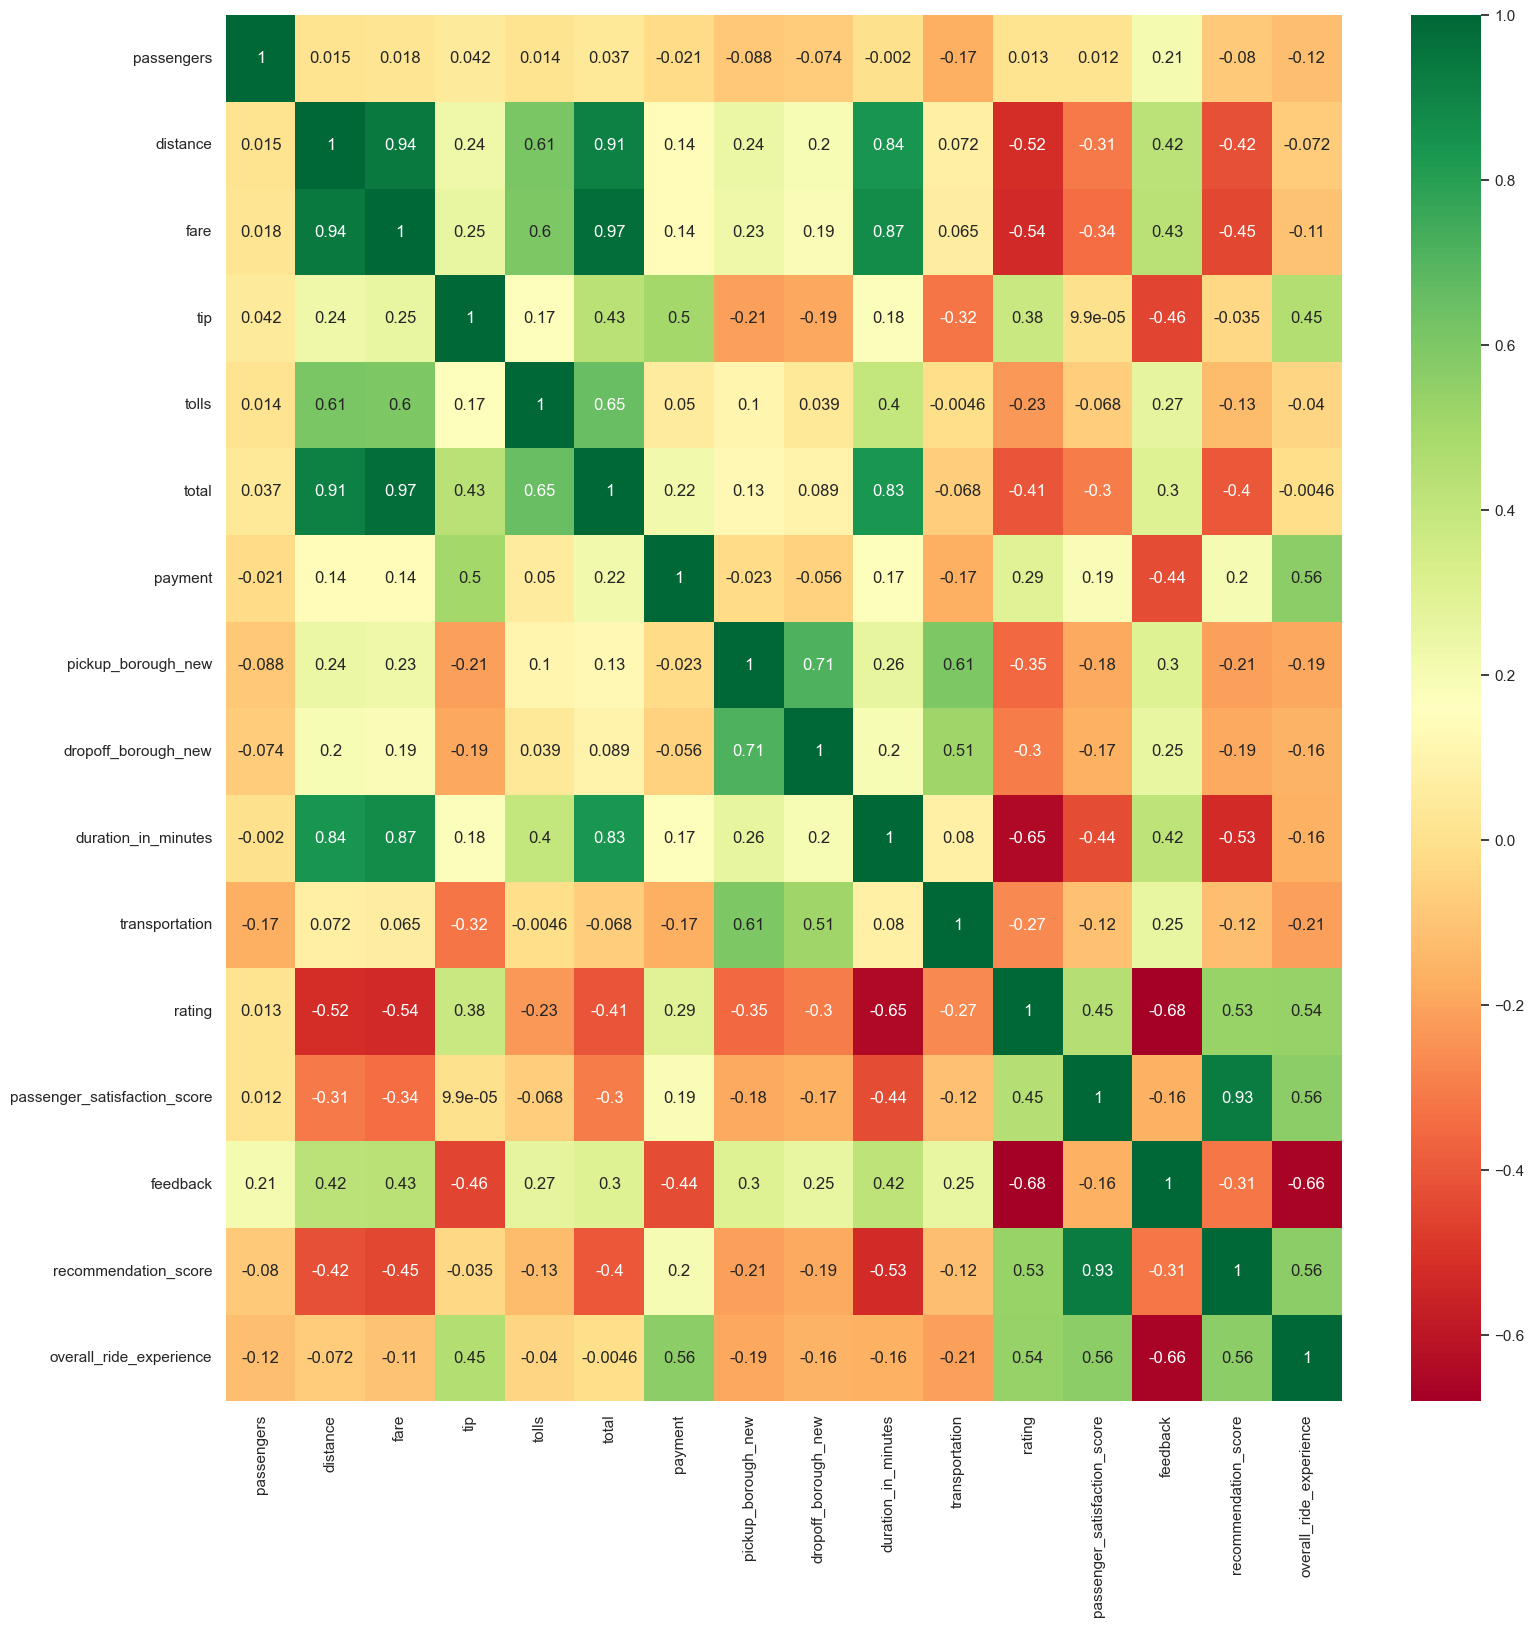

In [48]:
plt.figure(figsize=(18,18))
numeric_data = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(),annot=True,cmap='RdYlGn')

plt.show()

From the heatmap above, extreme green means highly positively correlated features (relationship between two variables in which both variables move in the same direction), extreme red means negatively correlated features (relationship between two variables in which an increase in one variable is associated with a decrease in the other).

Now, we can use the `corr()` function to calculate and list the correlation between all independent variables and the 'price'.



In [49]:
features = numeric_data.corr()['total'].sort_values()
features

rating                         -0.407619
recommendation_score           -0.401466
passenger_satisfaction_score   -0.299921
transportation                 -0.068069
overall_ride_experience        -0.004581
passengers                      0.037005
dropoff_borough_new             0.088868
pickup_borough_new              0.126697
payment                         0.221779
feedback                        0.303891
tip                             0.430929
tolls                           0.653679
duration_in_minutes             0.831523
distance                        0.914284
fare                            0.973816
total                           1.000000
Name: total, dtype: float64

<Axes: >

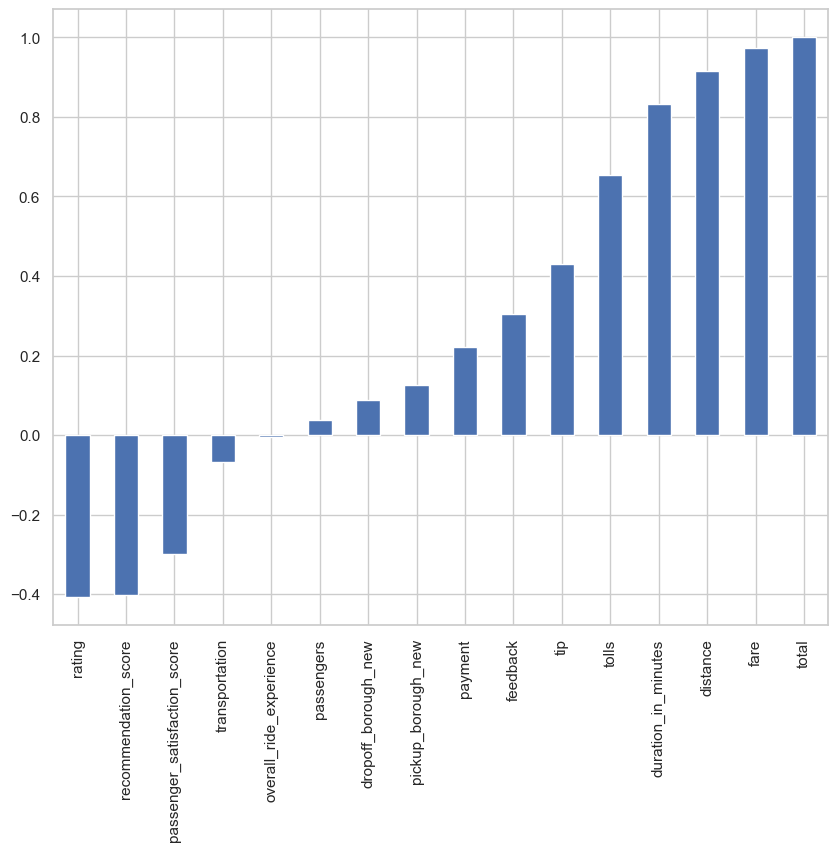

In [50]:
features.plot(kind='bar',figsize=(10,8))

---------------------------------------------------------------

# ****Analysis of Taxi Service Data with Demographic and Ride Details****



## **Demographic Variables and Ride Details**

* Transport Type: Local cab or rideshare platforms (e.g., Uber).
* Vehicle Type and Model: Characteristics of the vehicles used.
* Ride Type: Shared or solo rides.
* Day of the Week: Analysis by weekday patterns.
* Number of Passengers: How group size impacts other metrics.
* Distance Traveled: Total trip length.
* Trip Duration: Total time spent on the trip.
* Fare Amount: Cost of the ride.

## **Response Variables**

* Passenger Satisfaction Score: User-reported satisfaction rating.
* Feedback and Complaints: Qualitative insights into service issues.
* Overall Ride Experience: Holistic evaluation of the trip.

# ****Descriptive Analysis****
## Measure 1: Fare Amount

* **Objective:** 
    * Identify pricing differences between local cab services and rideshare platforms.
    * Understand the distribution of fare amounts within each service type.

* **Key Descriptives:**
    * Average fare
    * Range of fares
    * Variability of fares (standard deviation)
    * Skewness and kurtosis

In [51]:
# 0: TAXI , 1: Ride Share Platfrom
print(f"{df[df['transportation'] == 0]['fare'].describe()}\n---------------\n{df[df['transportation'] == 1]['fare'].describe()}")

print('\n')

print(f"Taxi:\nSkewness: {df[df['transportation'] == 0]['fare'].skew()}\nKurtosis: {df[df['transportation'] == 0]['fare'].kurt()}\n--------------------------")
print(f"Ride-share platform:\nSkewness: {df[df['transportation'] == 1]['fare'].skew()}\nKurtosis: {df[df['transportation'] == 1]['fare'].kurt()}")


count    982.000000
mean      12.492688
std       11.092468
min        2.500000
25%        6.500000
50%        9.000000
75%       14.500000
max      150.000000
Name: fare, dtype: float64
---------------
count    982.000000
mean      14.040886
std       12.790047
min        2.500000
25%        6.500000
50%        9.500000
75%       16.037500
max      150.000000
Name: fare, dtype: float64


Taxi:
Skewness: 4.082119784565256
Kurtosis: 31.111177856975115
--------------------------
Ride-share platform:
Skewness: 3.1880034850520307
Kurtosis: 18.07084497169779



* **Findings:**
    * **Ride-sharing platforms:** 
        * Average fare: \$14
        * Wide fare range (up to \$150)
        * Standard deviation: \$12.79
    * **Local cabs:**
        * Average fare: \$12.32
        * Fare range peaks at \$150.56
        * Standard deviation: \$11
        * Higher skewness (4.0) and kurtosis (31.11), indicating a greater likelihood of unusually high fares.


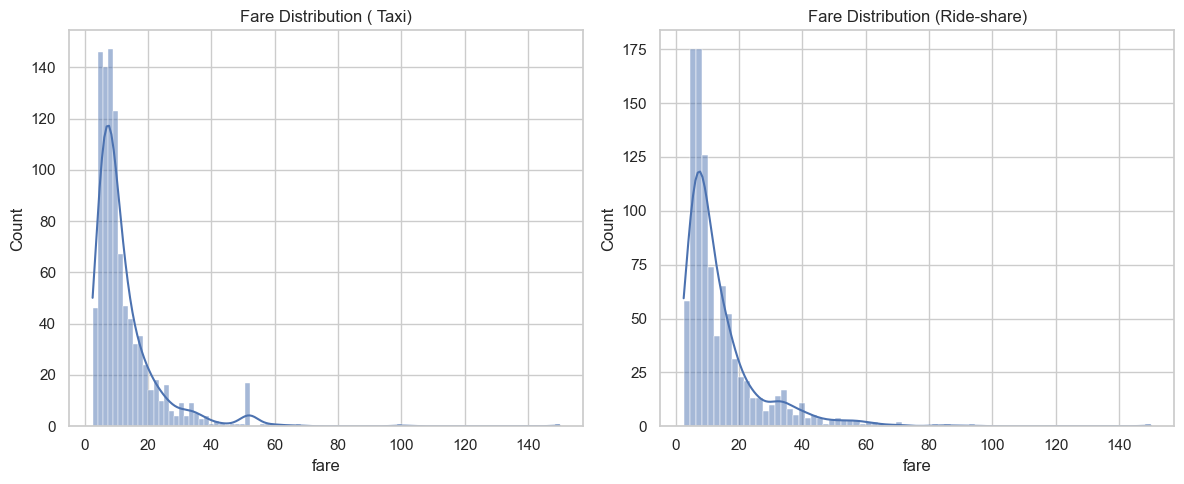

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df[df['transportation'] == 0]['fare'], kde=True, ax=axes[0])
axes[0].set_title('Fare Distribution ( Taxi)')


sns.histplot(df[df['transportation'] == 1]['fare'], kde=True, ax=axes[1])
axes[1].set_title('Fare Distribution (Ride-share)')

# Display the plots
plt.tight_layout()
plt.show()

## **Interpretation:** 
The descriptives of ride-share platforms and local cab services reveal that ride-share platforms are generally more affordable with an average fare of $14 compared to $12.32 for local cabs. Both services show a wide variation in fares, with standard deviations of $12.79 for ride-shares and $11 for local cabs, indicating that fares can range significantly. However, ride-shares have a wider fare range, reaching up to $150, while local cabs peak at $150.56. The local cab fares are more strongly skewed to the right (skewness of 4.0) and have kurtosis of 31.11, meaning they are more likely to have unusually high fares.

---------------------------------------------------------



## **Measure 2: Passenger Satisfaction Score**

* **Objective:** 
    * Satisfaction scores serve as an indicator of user experience and overall service quality to evaluate preferences over local cabs and rideshare platforms.
    * Descriptive statistics and visualizations, such as box plots and bar chart, will be used to compare the two categories, highlighting central tendencies and variability. 
    * We aim to identify which service type achieves higher satisfaction, reflecting passenger preference in the dataset.

* **Analysis Methods:**
    * Descriptive statistics (mean, median, standard deviation)
    * Box plots
    * Bar charts

In [53]:
# 0: TAXI , 1: Ride Share Platfrom

print(f"{df[df['transportation'] == 0]['passenger_satisfaction_score'].describe()}\n---------------\n{df[df['transportation'] == 1]['passenger_satisfaction_score'].describe()}")

print('\n')

print(f"Taxi:\nSkewness: {df[df['transportation'] == 0]['passenger_satisfaction_score'].skew()}\nKurtosis: {df[df['transportation'] == 0]['passenger_satisfaction_score'].kurt()}\n--------------------------")
print(f"Ride-share platform:\nSkewness: {df[df['transportation'] == 1]['passenger_satisfaction_score'].skew()}\nKurtosis: {df[df['transportation'] == 1]['passenger_satisfaction_score'].kurt()}")



count    982.000000
mean       2.572301
std        1.313448
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: passenger_satisfaction_score, dtype: float64
---------------
count    982.000000
mean       2.285132
std        1.149464
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: passenger_satisfaction_score, dtype: float64


Taxi:
Skewness: -0.07920574755129757
Kurtosis: -1.7213354332936421
--------------------------
Ride-share platform:
Skewness: 0.21421130983203246
Kurtosis: -1.3724418289293128



* **Findings:**
    * **Ride-sharing platforms:** 
        * Average fare: \$2
        * Wide fare range (up to \$50)
        * Standard deviation: \$1.14
    * **Local cabs:**
        * Average fare: \$2.5
        * Fare range peaks at \$5
        * Standard deviation: \$1.31
        * Higher skewness (0.212) and kurtosis (-1.3), indicating a greater likelihood of unusually high fares.


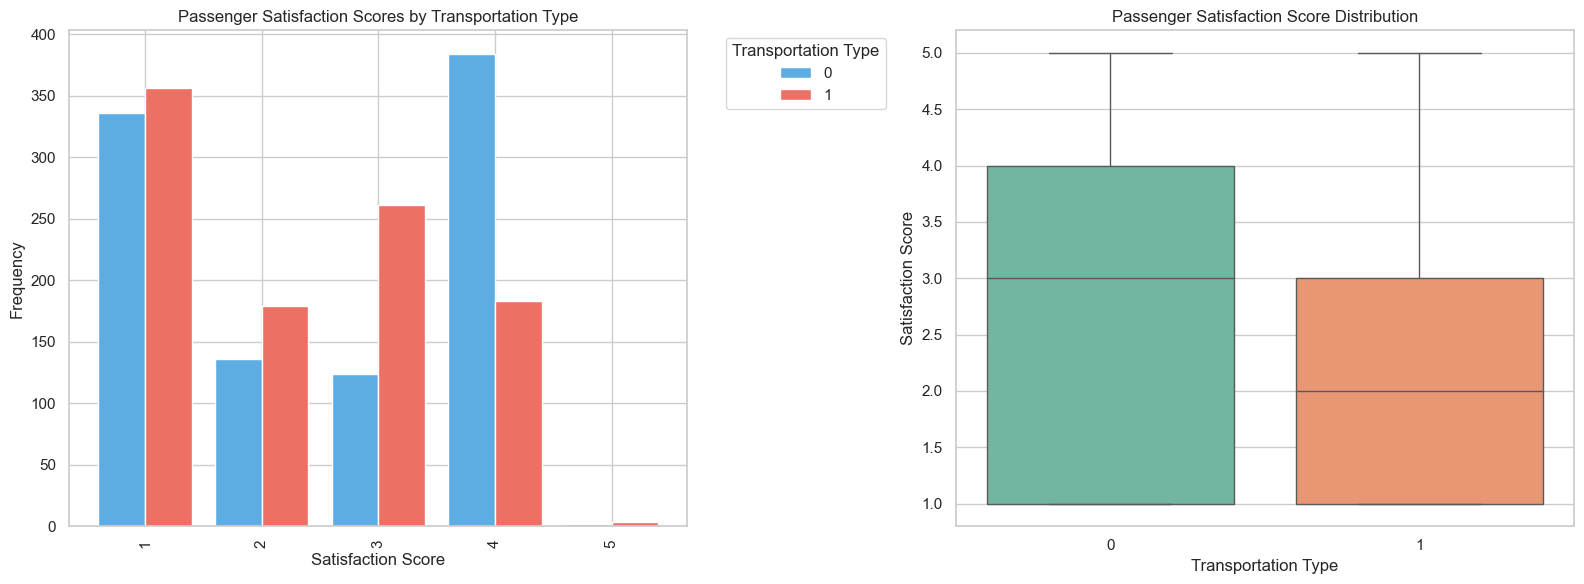

In [54]:
# 0: TAXI , 1: Ride Share Platfrom

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
score_counts = df.groupby(['transportation', 'passenger_satisfaction_score']).size().unstack(fill_value=0)
# Multiple bar chart
score_counts.T.plot(kind='bar', ax=axes[0], color=['#5DADE2', '#EC7063'], width=0.8)
axes[0].set_title('Passenger Satisfaction Scores by Transportation Type')
axes[0].set_xlabel('Satisfaction Score')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Transportation Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Box plot
sns.boxplot(x='transportation', y='passenger_satisfaction_score', data=df, ax=axes[1], palette="Set2")
axes[1].set_title('Passenger Satisfaction Score Distribution')
axes[1].set_xlabel('Transportation Type')
axes[1].set_ylabel('Satisfaction Score')

plt.tight_layout()
plt.show()



* **Interpretation:**

    * **Box Plot:** The box plot shows that Rideshare Platforms have a lower median satisfaction score around 2 with a tightly clustered box ranging from 1 to 3, indicating lower satisfaction. Whereas, Local Cabs have the median score around 3 with a wider range, indicating slightly better variability and satisfaction. Both are extended up to 5, indicating both have some high scores, but less common for Rideshare Platforms.

    * **Bar Chart:** It shows that Local Cabs outperform the Rideshare Platforms particularly in the satisfied category. Rideshare Platforms have a higher proportion of Neutral and Dissatisfied responses, indicating a need for improvement. Whereas, the high counts in the Very Dissatisfied category, indicates that both services have general issues with customer experience.

-------------------------------




## Measure 3: Trip Duration

* **Objective:** 
    * This analysis explores trip duration as a factor influencing passenger preferences between local cabs and rideshare platforms. 
    Trip duration, measured in `[minutes/hours]`, reflects service efficiency and reliability. 
    By examining differences in trip durations with the help of descriptives and graphs, we aim to understand whether one service type offers a time advantage that may drive passenger preference.


In [55]:
# 0: TAXI , 1: Ride Share Platfrom

print(f"{df[df['transportation'] == 0]['duration_in_minutes'].describe()}\n---------------\n{df[df['transportation'] == 1]['duration_in_minutes'].describe()}")

print('\n')

print(f"Taxi:\nSkewness: {df[df['transportation'] == 0]['duration_in_minutes'].skew()}\nKurtosis: {df[df['transportation'] == 0]['duration_in_minutes'].kurt()}\n--------------------------")
print(f"Ride-share platform:\nSkewness: {df[df['transportation'] == 1]['duration_in_minutes'].skew()}\nKurtosis: {df[df['transportation'] == 1]['duration_in_minutes'].kurt()}")



count    982.000000
mean      13.581466
std       10.489108
min        0.000000
25%        7.000000
50%       10.000000
75%       18.000000
max       76.000000
Name: duration_in_minutes, dtype: float64
---------------
count    982.000000
mean      15.600815
std       14.317697
min        0.000000
25%        6.000000
50%       11.000000
75%       20.000000
max      108.000000
Name: duration_in_minutes, dtype: float64


Taxi:
Skewness: 1.99444424048594
Kurtosis: 5.992931457317619
--------------------------
Ride-share platform:
Skewness: 2.067497288591347
Kurtosis: 5.56918273457911


    

* **Findings:**
    * **Ride-sharing platforms:**
        * Mean duration: 15.73 minutes
        * Standard deviation: 14.31 minutes
        * Wider range of durations (0 to 108 minutes)
        * Higher skewness (2.06), indicating a greater likelihood of longer trips.
    * **Local cabs:**
        * Mean duration: 13.58 minutes
        * Standard deviation: 10.48 minutes
        * Range of durations (0 to 76 minutes)
        * Moderate skewness.




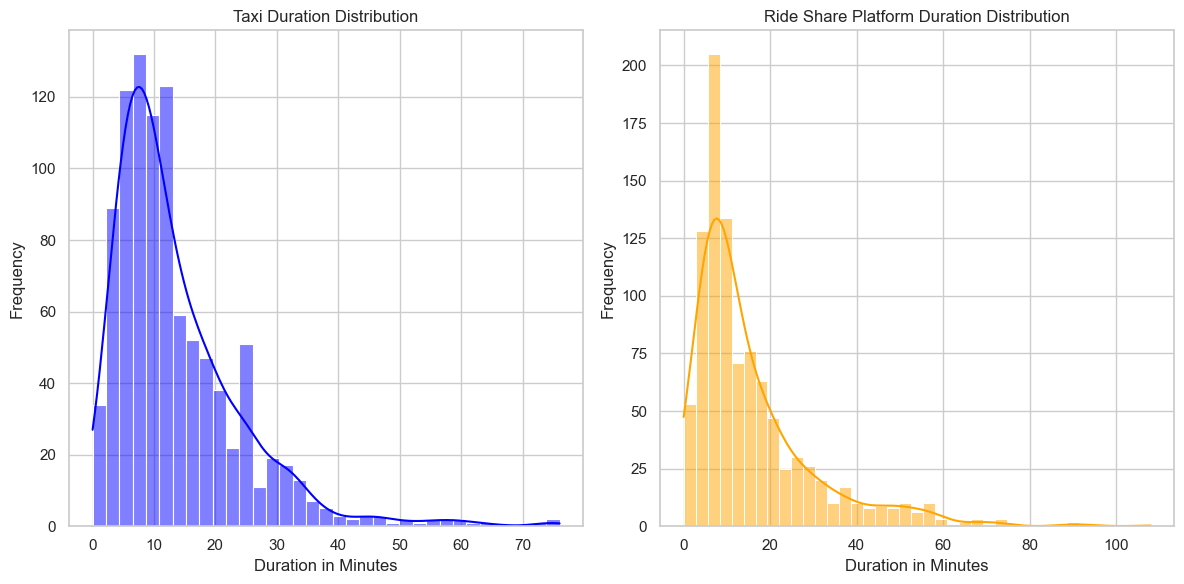

In [56]:

# Histograms
plt.figure(figsize=(12, 6))

# Histogram for Taxi
plt.subplot(1, 2, 1)
sns.histplot(df[df['transportation'] == 0]['duration_in_minutes'], kde=True, color='blue')
plt.title('Taxi Duration Distribution')
plt.xlabel('Duration in Minutes')
plt.ylabel('Frequency')

# Histogram for Ride Share Platform
plt.subplot(1, 2, 2)
sns.histplot(df[df['transportation'] == 1]['duration_in_minutes'], kde=True, color='orange')
plt.title('Ride Share Platform Duration Distribution')
plt.xlabel('Duration in Minutes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

* **Interpretation:**
    The comparison of trip durations between ride-share platforms and local cabs shows that ride-share trips are slightly longer on average. The mean duration for ride-shares is 15.73 minutes, compared to 13.74 minutes for local cabs, though both have the same median of 11 minutes, indicating that typical trips are similar in duration. However, ride-shares exhibit greater variability, with a standard deviation of 14.17 compared to 10.40 for local cabs, and a wider range of durations (0 to 108 minutes for ride-shares vs. 0 to 75 minutes for local cabs). Both distributions are right-skewed, meaning most trips are shorter, but ride-shares have a slightly stronger skewness (2.02), suggests that while most trips for both services are short, ride-shares are more likely to have unusually long trips. 

# ****Hypothesis Testing****


# **Test I: Overview**

* The test is being applied to analyze the variation in fare amounts across different ride types (e.g., AC, Economy, and Shared).
* The purpose of this test is to assess whether the type of ride has a significant impact on the fare amount, helping to identify cost differences among ride categories offered by both services.
* The test being performed here is one-way ANOVA with 5% level of significance, assuming population normality and homogeneity of variances. 
* If the data does not meet the assumptions, then we will either move towards Welch ANOVA or a non-parametric version of one-way ANOVA (Kruskal-Wallis H test).

**Hypothesis:**

* **Null Hypothesis (H0):** There is no significant difference between mean fares of ride types. OR μ1 = μ2 = μ3
* **Alternative Hypothesis (H1):** At least one ride type has a mean fare amount significantly different from the others.

**Level of Significance:** α = 0.05

**Analyses:**

* **Checking the normality of data:**

In [57]:
ride_types = df['ride_type'].unique()
normality_results = {}

for ride_type in ride_types:
    subset = df[df['ride_type'] == ride_type]['fare']
    normality_results[ride_type] = kstest(subset, 'norm', args=(subset.mean(), subset.std()))

print("Normality Test Results (Kolmogorov-Smirnov):")
for ride_type, result in normality_results.items():
    print(f"{ride_type}: p-value = {result.pvalue:.4f}")

Normality Test Results (Kolmogorov-Smirnov):
AC: p-value = 0.0000
Economy: p-value = 0.0000
Shared: p-value = 0.0064


* **Interpretation**:
    * The p-value from the Kolmogorov-Smirnov test for AC and economy rides is less than significance level (0.05) and greater for shared rides. So, we conclude that the assumption
    of normality is violated for AC and economy rides and is fulfilled for shared rides. Therefore, the assumption of normality is moderately violated.
 
* Checking the homogeneity of variances:



In [58]:
levene_stat, levene_p = levene(
    *[df[df['ride_type'] == rt]['fare'] for rt in ride_types]
)
print(f"\nLevene's Test for Homogeneity of Variances: p-value = {levene_p:.4f}")


Levene's Test for Homogeneity of Variances: p-value = 0.0000


**Interpretation:**

* As the p-value from Levene's test is less than the level of significance (0.05), it indicates that the assumption of equal variances across the three ride types (AC, Economy, Shared) is violated. 
* Therefore, we cannot proceed with the classic one-way ANOVA. 
* If the homogeneity of variances is not fulfilled, alternative tests like Welch ANOVA, Brown-Forsythe ANOVA, or the Kruskal-Wallis H test (a non-parametric alternative) can be considered.

**Welch ANOVA test:**
* The most suitable and appropriate test in this scenario would be Welch’s ANOVA, because it adjusts for unequal variances and can handle moderate violations of normality, especially with large sample sizes.



In [59]:
if levene_p > 0.05:
    # Perform One-way ANOVA
    f_stat, p_value = f_oneway(
        *[df[df['ride_type'] == rt]['fare'] for rt in ride_types]
    )
    print(f"\nOne-way ANOVA: F = {f_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("Significant differences found between groups.")
    else:
        print("No significant differences between groups.")
else:
    # Aggregate data
    aggregated_df = df.groupby('ride_type', as_index=False).agg({'fare': 'mean'})
    
    # Perform Welch ANOVA using aggregated data
    print("\nUsing Welch ANOVA as variances are not homogeneous.")
    try:
        welch_anova = AnovaRM(data=aggregated_df, depvar='fare', subject='ride_type', within=['ride_type']).fit()
        print(welch_anova.summary())
    except Exception as e:
        print(f"Error during Welch ANOVA: {e}")


Using Welch ANOVA as variances are not homogeneous.
Error during Welch ANOVA: 'C(ride_type, Sum):C(ride_type, Sum)'


**Interpretation:**
* As the p-value is less than the level of significance (0.05), so we reject the null hypothesis and conclude that the mean fare amount is different for all three types of rides.

**Post-Hoc Test:**
* The test we conduct here is  Games-Howell post-hoc test, to determine pairwise differences between the ride types (AC, Economy, and Shared) with respect to the dependent variable fare. 
* This test is suitable for this situation where the assumption of equal variances across groups may not hold, making it a robust method for comparing means across groups with unequal variances.



In [60]:
# posthoc_results = pg.pairwise_gameshowell(data=df, dv='fare', between='ride_type') 

# # Create a pivot table to match the structure of the provided image
# pivot_table = posthoc_results.pivot_table(index='A', columns='B', values='diff')
# pivot_table['Sig.'] = posthoc_results['p-adj'].values.reshape(pivot_table.shape)

# print("\nPost-hoc Comparisons Table:")
# print(pivot_table) 

Conclusion:
AC vs Economy: There is a significant difference between the AC and Economy ride types (p-value<0.05), with AC fares being higher by 16.07 units.
AC vs Shared: AC fares are significantly higher than Shared fares by 15.80 units (p-value<0.05).
Economy vs Shared: There is no significant difference between the Economy and Shared ride types in terms of fare (p-value>0.05).
The results indicate that the rides having AC charge high fares and are dominant as compared to Economy and Shared rides. However, there is no significant difference in the fares of Economy and Shared rides. They are quite similar.


# **Test II:**
 Overview The following test is being applied to analyze whether the average ride duration significantly differs between the two types of transportation: local cabs and rides like Uber. Such an analysis is critical for understanding variations in ride performance and passenger preferences. Given that we are comparing the means of two independent groups (local cabs and Uber-like services), and assuming the data is approximately normally distributed, we will apply two independent samples t-test. Alternatively, if the data does not meet normality assumptions, a non-parametric test like the Mann-Whitney U test can be employed.



**Hypothesis:**
*  Null Hypothesis (H0): The average duration of rides for both transportation is same. OR μ1 = μ2 
* Alternative Hypothesis (H1): The average duration of rides for both transportation is different. OR μ1 ≠ μ2

* Level of Significance: α = 0.05 
  
**Analyses: Checking the normality of data:**


Kolmogorov-Smirnov Test for Taxi: Statistic = 0.1495, p-value = 0.0000
Kolmogorov-Smirnov Test for Ride-share platform: Statistic = 0.1766, p-value = 0.0000


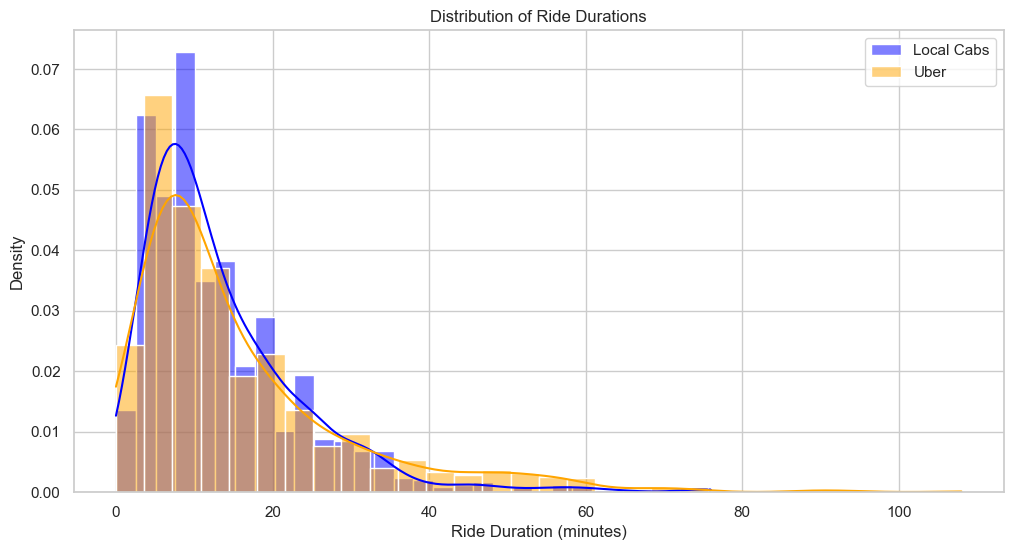

In [61]:
# Step 1: Check normality using the Kolmogorov-Smirnov test
ks_local = stats.kstest(df[df['transportation'] == 0]['duration_in_minutes'], 'norm', args=(df[df['transportation'] == 0]['duration_in_minutes'].mean(), df[df['transportation'] == 0]['duration_in_minutes'].std()))
ks_uber = stats.kstest(df[df['transportation'] == 1]['duration_in_minutes'], 'norm', args=(df[df['transportation'] == 1]['duration_in_minutes'].mean(), df[df['transportation'] == 1]['duration_in_minutes'].std()))

print("Kolmogorov-Smirnov Test for Taxi: Statistic = {:.4f}, p-value = {:.4f}".format(ks_local.statistic, ks_local.pvalue))
print("Kolmogorov-Smirnov Test for Ride-share platform: Statistic = {:.4f}, p-value = {:.4f}".format(ks_uber.statistic, ks_uber.pvalue))

# Step 2: Visualize the distributions
plt.figure(figsize=(12, 6))
sns.histplot(df[df['transportation'] == 0]['duration_in_minutes'], color='blue', label='Local Cabs', kde=True, stat="density", bins=30)
sns.histplot(df[df['transportation'] == 1]['duration_in_minutes'], color='orange', label='Uber', kde=True, stat="density", bins=30)
plt.title('Distribution of Ride Durations')
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Density')
plt.legend()
plt.show()


Interpretation:
As the p-values obtained from Kolmogorov-Smirnov test are less than significance level (0.05), so the data for both variables is not normally distributed.
But according to Central Limit Theorem (CLT), with a sufficiently large sample size, the sampling distribution of the mean approaches normality regardless of the population's underlying distribution. Thus, the t-test becomes robust to violations of normality. Since we have a large dataset, the two samples t-test is generally a valid choice.



In [71]:
import scipy
# Step 3: Levene's test for equal variances
levene_test = scipy.stats.levene(df[df['transportation'] == 0]['duration_in_minutes'], df[df['transportation'] == 1]['duration_in_minutes'])
print("Levene's Test: Statistic = {:.4f}, p-value = {:.4f}".format(levene_test.statistic, levene_test.pvalue))



Levene's Test: Statistic = 22.8573, p-value = 0.0000


Interpretation:
As the p-value obtained from Levene’s test (equal variances) is less than significance level. So, we draw conclusions on the test-statistics of unequal variances i.e., p-value (0.000) < significance level (0.05). Therefore, we reject the null hypothesis and conclude that the mean duration of rides for local cabs and rideshare platforms is significantly different.


In [72]:
# Step 4: Two independent samples t-test
if levene_test.pvalue < 0.05:
    # If variances are not equal, use Welch's t-test
    t_test = stats.ttest_ind(df[df['transportation'] == 0]['duration_in_minutes'], df[df['transportation'] == 1]['duration_in_minutes'], equal_var=False)
else:
    # If variances are equal, use standard t-test
    t_test = stats.ttest_ind(df[df['transportation'] == 0]['duration_in_minutes'], df[df['transportation'] == 1]['duration_in_minutes'], equal_var=True)

print("T-test: Statistic = {:.4f}, p-value = {:.4f}".format(t_test.statistic, t_test.pvalue))

T-test: Statistic = -3.5653, p-value = 0.0004


Interpretation:
As the p-values obtained from Kolmogorov-Smirnov test are less than significance level (0.05), so the data for both variables is not normally distributed.
But according to Central Limit Theorem (CLT), with a sufficiently large sample size, the sampling distribution of the mean approaches normality regardless of the population's underlying distribution. Thus, the t-test becomes robust to violations of normality. Since we have a large dataset, the two samples t-test is generally a valid choice.



# **Correlations**

# **B/w Fares & Days of Week: Overview**
In this analysis, we aim to investigate whether the values of fare charged vary systematically with specific days and analyze the strength of the correlation coefficient between them.
Since "days of the week" is a categorical variable and "fare" is a continuous variable, a correlation analysis can be conducted using appropriate techniques to evaluate the association.
In the case when we have to check correlation between a continuous and a categorical variable, Spearman’s rank correlation can be employed.

### **Hypothesis:**
* Null Hypothesis (H0): There is no association between fares and days of week. OR ρ = 0
* Alternative Hypothesis (H1): There is association between fares and days of week. OR ρ ≠ 0

**Level of Significance:** α = 0.05

In [99]:
day_mapping = {'Weekday': 1, 'Weekend': 2}
df['day_numeric'] = df['day_of_week'].map(day_mapping)

In [100]:
# Calculate Spearman's rank correlation
spearman_corr, p_value = scipy.stats.spearmanr(df['fare'], df['day_numeric'])

print(f"Spearman's Rank Correlation Coefficient: {spearman_corr}")
print(f"P-Value: {p_value}")

Spearman's Rank Correlation Coefficient: -0.02139874990619324
P-Value: 0.34321395630153184


## **Interpretation:**
As the p-value (0.343) is greater than significance level (0.05), so we accept the null hypothesis and conclude that there is no association between fares and days of week.

**Correlation Coefficient:**
The correlation coefficient between fares and days of week (-0.021), suggests that there is a weak negative correlation between them and as the days of the week changes the fare tends to slightly decrease , but the relationship is almost negligible.


## **B/w Overall Ride Experience & Recommendation Score:**
In this analysis, we will determine whether there is an association between overall ride experience and recommendation score. If they do, then to what extent.
As both variables are ordinal, so again Spearman’s rank correlation can be employed.

**Hypothesis:**
* Null Hypothesis (H0): There is no association between overall ride experience and recommendation score. OR ρ = 0
* Alternative Hypothesis (H1): There is association between overall ride experience and recommendation score. OR
     ρ ≠ 0
     
**Level of Significance:** α = 0.05

In [102]:
from scipy.stats import spearmanr

# Calculate Spearman's rank correlation
spearman_corr, p_value = spearmanr(df['overall_ride_experience'], df['recommendation_score'])

# Print results
print(f"Spearman's Rank Correlation Coefficient: {spearman_corr}")
print(f"P-Value: {p_value}")

Spearman's Rank Correlation Coefficient: 0.5738160330301291
P-Value: 2.202498981233639e-172


## **Interpretation:**
As the p-value (<.001) is less than the significance level (0.05), so we reject the null hypothesis and conclude that there is an association between overall ride experience and recommendation scores.

**Correlation Coefficient:** 
* A correlation of 0.573 indicates a positive correlation between the two variables. This means that as the overall ride experience improves, the recommendation score also tends to increase. The positive sign of the coefficient suggests a direct relationship i.e., better ride experiences are associated with higher recommendation scores.


---------------------------------------------


## Insights and Implications

To summarize the main findings:  
* The key findings we got here that, ride-share platforms appear to dominate in affordability and flexibility, making them preferable for short and cost-effective rides, while local cabs, though slightly more expensive, provide more consistent pricing and trip durations. 

* We observed that AC rides are outperforming the Economy and Shared rides. Rideshares are budget-friendly but are not consistent in service quality, like trip duration. Whereas, Local Cabs are slightly expensive but are consistent.  

* We also observed there were high rates of lower satisfaction for both of the transportations. For Rideshares, that can be due to some technical problems like app glitches and long wait times may have contributed, and for Local Cabs like lack of driver professionalism, pricing issues, etc.  

* These insights suggest that passenger preferences may lean toward ride-shares for affordability and versatility, but local cabs still hold value for predictable and stable travel experiences.  

---

## Limitations and Future Work

### Limitations:
- **Limited Time Frame**: The dataset only covers a two-month period (March 2019 to April 2019), which may not fully represent seasonal trends or long-term patterns in passenger preferences and taxi service performance.  
- **Geographical Scope**: The dataset might be region-specific, limiting the ability to generalize findings to other areas with different transportation dynamics or customer behaviors.  
- **Data Gaps and Incompleteness**: There may be missing or incomplete data, such as missing feedback or incomplete trip details, which could impact the accuracy of analysis.  
- **Lack of External Factors**: The dataset does not account for external variables like weather, holidays, or city events, which could significantly affect taxi demand and service levels.  

### Future Work:
- **Expand the Dataset**: Extend the analysis to include data over a longer time period or from multiple years to capture seasonal and long-term trends.  
- **Include External Factors**: Incorporate external factors such as weather conditions, local events, and holidays to understand their impact on taxi service demand and passenger preferences.  
- **Geographical Analysis**: Analyze the dataset across different regions to compare the performance and customer preferences for taxis in different locations.  
- **Mobile App Data Integration**: By using data from mobile apps or GPS systems, we can track real-time locations and routes, helping to improve driver performance and service efficiency.  

---

## Conclusion

In summary, this analysis of ride-share platforms and local taxi services provides valuable insights into passenger preferences, fare structures, passenger satisfaction scores, ride types, and trip durations.  
Ride-share platforms tend to offer more affordable fares with greater flexibility, making them ideal for short trips, while local cabs provide consistent pricing and reliable services for passengers seeking stability.  
By understanding these patterns, transportation providers can better tailor their services to meet consumer needs. The findings also open avenues for further exploration, such as expanding the dataset, integrating real-time data, and exploring external factors that influence service demand.  
Ultimately, these insights can help improve customer satisfaction and optimize operational strategies for both ride-share platforms and local taxi services.  

______________________________________________


## Ahmed Raza

* **LinkedIn:** [Ahmed Raza](https://www.linkedin.com/in/ahmedrzzaa/) 
* **Github:** [Ahmed Raza](https://github.com/ahmedrzaa) 